# Final Project Submission

Please fill out:
* Student name: Marco Giuseppe Nasuto
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL: https://coral.marconasuto.com/


In [611]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import matplotlib.lines as mlines
import seaborn as sns
import missingno as msno
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, plot_confusion_matrix, precision_recall_curve, plot_precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.base import BaseEstimator
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.pipeline import Pipeline as imbPipe
import xgboost as xgb  
from sklearn.cluster import KMeans
%matplotlib inline

In [10]:
def histhue(df, hue, save=False):
    sns.set_context('notebook', rc={'linewidth':1})
    palette = sns.color_palette("pastel")
    i = 0
    for col in df.columns:
        if col != hue:
            fig, ax = plt.subplots(1,2, figsize=(10,4))
            fig.tight_layout(w_pad=3)
            hist = sns.histplot(data=df, x=col, hue=hue, ax=ax[0], multiple='fill', stat='count', alpha=.8, palette=["powderblue", "coral"])
            hist_2 = sns.histplot(data=df, x=col, hue=hue, ax=ax[1], multiple='stack', stat='count', alpha=.8, palette=["powderblue", "coral"])
            hist.set_title('Histogram of {} by {}'.format(col, hue))
            hist_2.set_title('Histogram of {} by {}'.format(col, hue))
            hist.tick_params(axis='x', labelrotation=45)             
            hist_2.tick_params(axis='x', labelrotation=45) 
            if save:
                plt.savefig('./images/{}-by-{}.png'.format(col, hue), bbox_inches = "tight", dpi=300)

In [11]:
def statistics(df, target=None, jointplot=False, log=False, check_na=False):
    '''The fucntion returns a set of general statistics and information on a given dataframe df, target variable. When log=True the fucntion applies a log-transfromation to all numerical columns.:
    - .shape: shape of the dataframe
    - .info: dtype objects of each column and number of non-null objects
    - .describe: count, mean, std,  min, max, quartiles
    - .median: median of numerical columns in dataframe
    - nullity matrix: matrix that shows how filled variables are 
    - nullity dendogram: The dendrogram uses a hierarchical clustering algorithm (courtesy of scipy) to bin variables against one another by their nullity correlation (measured in terms of binary distance). At each step of the tree the variables are split up based on which combination minimizes the distance of the remaining clusters. The more monotone the set of variables, the closer their total distance is to zero, and the closer their average distance (the y-axis) is to zero. To interpret this graph, read it from a top-down perspective. Cluster leaves which linked together at a distance of zero fully predict one another's presence—one variable might always be empty when another is filled, or they might always both be filled or both empty, and so on. In this specific example the dendrogram glues together the variables which are required and therefore present in every record. Cluster leaves which split close to zero, but not at it, predict one another very well, but still imperfectly. If your own interpretation of the dataset is that these columns actually are or ought to be match each other in nullity (for example, as CONTRIBUTING FACTOR VEHICLE 2 and VEHICLE TYPE CODE 2 ought to), then the height of the cluster leaf tells you, in absolute terms, how often the records are "mismatched" or incorrectly filed—that is, how many values you would have to fill in or drop, if you are so inclined. As with matrix, only up to 50 labeled columns will comfortably display in this configuration. However the dendrogram more elegantly handles extremely large datasets by simply flipping to a horizontal configuration.
    - (isna.sum, perc_NaN): number of NaN values for each column and percentage of Nan values w.r.t each column total number of rows
    - (.duplicated, index_dupl): tuple with number of rows duplicated and indexes where .duplicated == True
    - .value_counts: Normalized unique values for each column in dataframe
    - .columns: list of columns of the dataframe
    - correlation matrix
    - boxplot: boxplots of numerical columns
    - hist: histograms of numerical columns
    - scatterplot: scatter plot for numerical columns
    - hist by target variable: histogram of columns with hue = target variable
\nParameters
----------
\ndf : DataFrame object
\ntarget: str, target column
    '''
    #mulitcollinearity with vif analysis 
    try:
        vif = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif_df = pd.DataFrame()
        vif_df['vif'] = vif
        vif_df['features'] = df.columns
        print(vif_df.sort_values(by='vif', ascending=False))
    except: print('VIF analysis not possible at the moment. Please fix dtypes of columns.')

    duplicated_index = df[df.duplicated()].index
    print('Shape: ', df.shape)
    print('\ndtype objects of each column and number of non-null objects:')
    print('\n')
    print(df.info())
    print('\ncount, mean, std, min, max, quartiles:')
    print('\n{}'.format(df.describe()))
    print('\nMedian values of numerical columns in the dataframe:')
    print('\n{}'.format(df.median()))
    print('\nNumber of NaN values per column:\n')
    print(df.isna().sum(), '\n\nIn terms of percentage (%) for each column\n\n',
          df.apply(lambda x: ((x.isna().sum())/len(x))*100))
    if check_na == True:
        msno.matrix(df)
        msno.dendrogram(df)
    print('\nNormalized unique values for each column in dataframe')
    for col in df.columns:
        if df[col].dtypes == np.number:
            print('\nColumn name: {}\n\n{}'.format(
                col, df[col].value_counts(normalize=True, dropna=False)))
        else:
            print('\nColumn name: {}\n\n{}'.format(
                col, df[col].value_counts(normalize=True, dropna=False)))
    print('Duplicated rows in the dataframe: ', df.duplicated().sum(),
          'Indexes where duplicated', duplicated_index)
    print('List of columns in the dataframe:')
    print(df.columns)
    plt.figure(figsize=(20, 20))
    sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)
    plt.figure(figsize=(20, 20))
    if log == True:
        logtransform(df)
    if (df.dtypes == bool).any():
        print('There is at least a boolean column')    
    df.select_dtypes(exclude=bool).hist(figsize=(20, 20))
    df.select_dtypes(exclude=bool).boxplot(figsize=(20, 20))
    for col in df.columns:
        try:
            if jointplot:
                g = sns.jointplot(x=col, y=target, data=df)
                #plt.title('Feature: {}'.format(col))
        except:
            print('{} is not a numerical column'.format(col))
    if target != None:
        try:
            histhue(df, target)
        except:
            print('It hasn\'t been possible to visualize histograms of each column w.r.t. {}'.format(target))
    return duplicated_index

# Load data

In [603]:
ls

external/           processed/          telcom-dataset.csv
images/             raw/


In [606]:
#directory where data is
os.chdir('./data')

FileNotFoundError: [Errno 2] No such file or directory: './data'

In [14]:
#path to export data
path = "./processed"

In [15]:
original_df = pd.read_csv('./raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [16]:
original_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


VIF analysis not possible at the moment. Please fix dtypes of columns.
Shape:  (7043, 21)

dtype objects of each column and number of non-null objects:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
Mon

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:2837: UserWarning:

Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.




Normalized unique values for each column in dataframe

Column name: customerID

2428-ZMCTB    0.000142
3500-RMZLT    0.000142
6267-DCFFZ    0.000142
0584-BJQGZ    0.000142
2239-CGBUZ    0.000142
                ...   
5242-UOWHD    0.000142
9091-WTUUY    0.000142
7560-QJAVJ    0.000142
6311-UEUME    0.000142
2665-NPTGL    0.000142
Name: customerID, Length: 7043, dtype: float64

Column name: gender

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

Column name: SeniorCitizen

0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64

Column name: Partner

No     0.516967
Yes    0.483033
Name: Partner, dtype: float64

Column name: Dependents

No     0.700412
Yes    0.299588
Name: Dependents, dtype: float64

Column name: tenure

1     0.087037
72    0.051399
2     0.033792
3     0.028397
4     0.024989
        ...   
28    0.008093
39    0.007951
44    0.007241
36    0.007099
0     0.001562
Name: tenure, Length: 73, dtype: float64

Column name: PhoneService

Yes  

Int64Index([], dtype='int64')

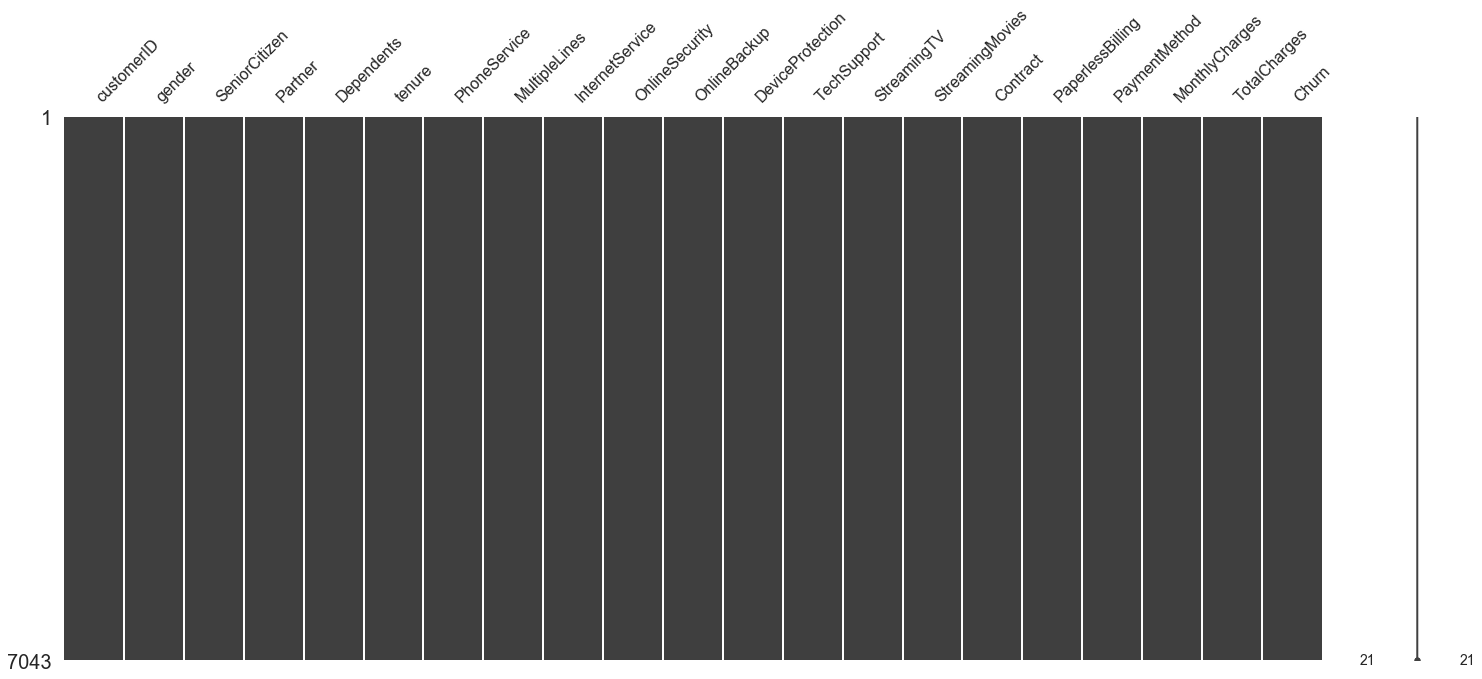

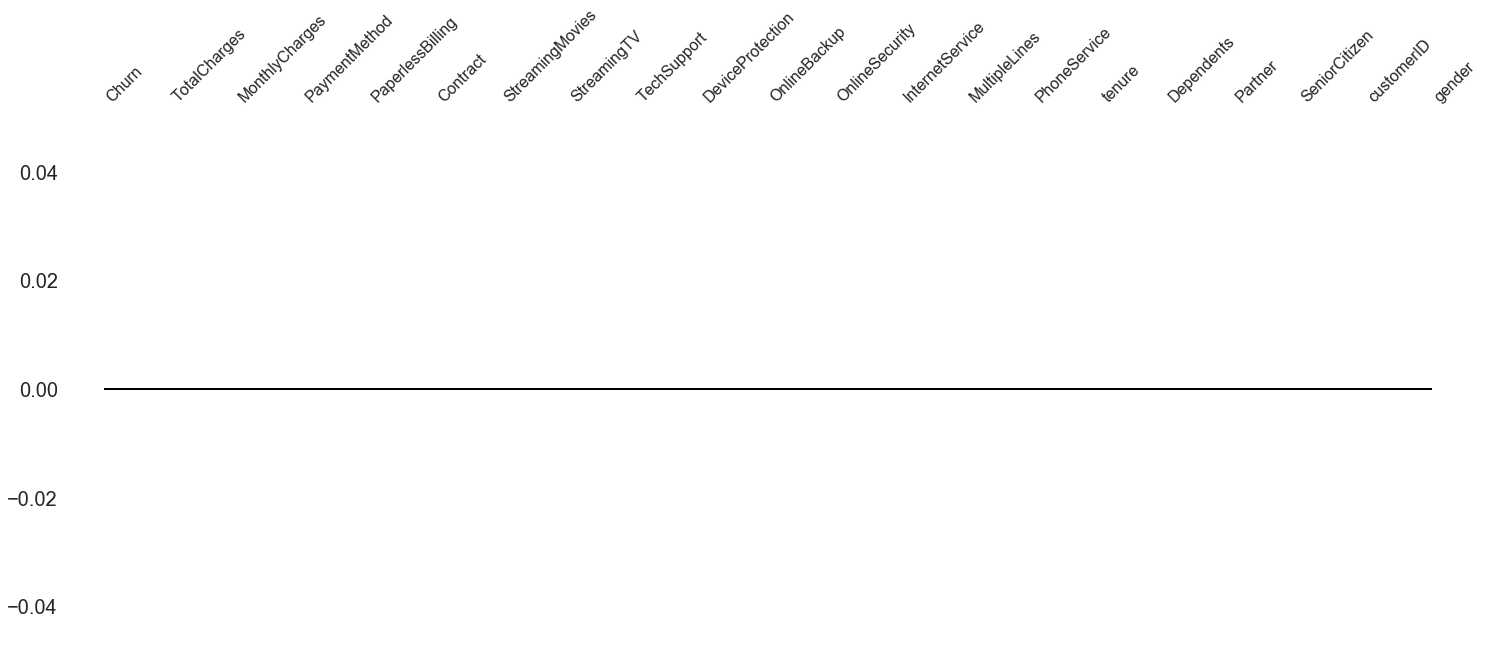

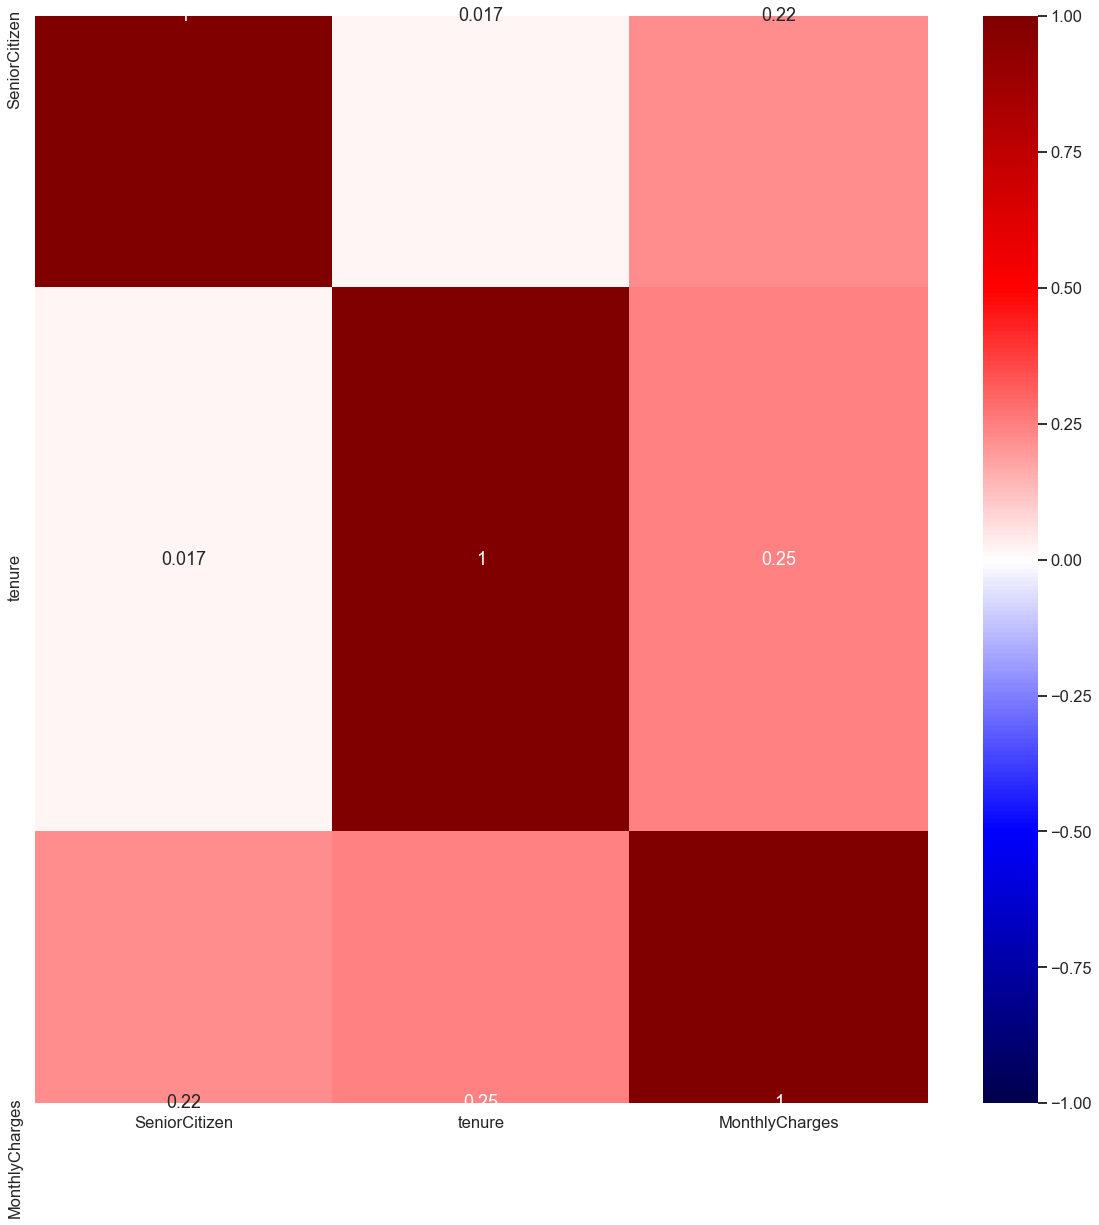

<Figure size 1440x1440 with 0 Axes>

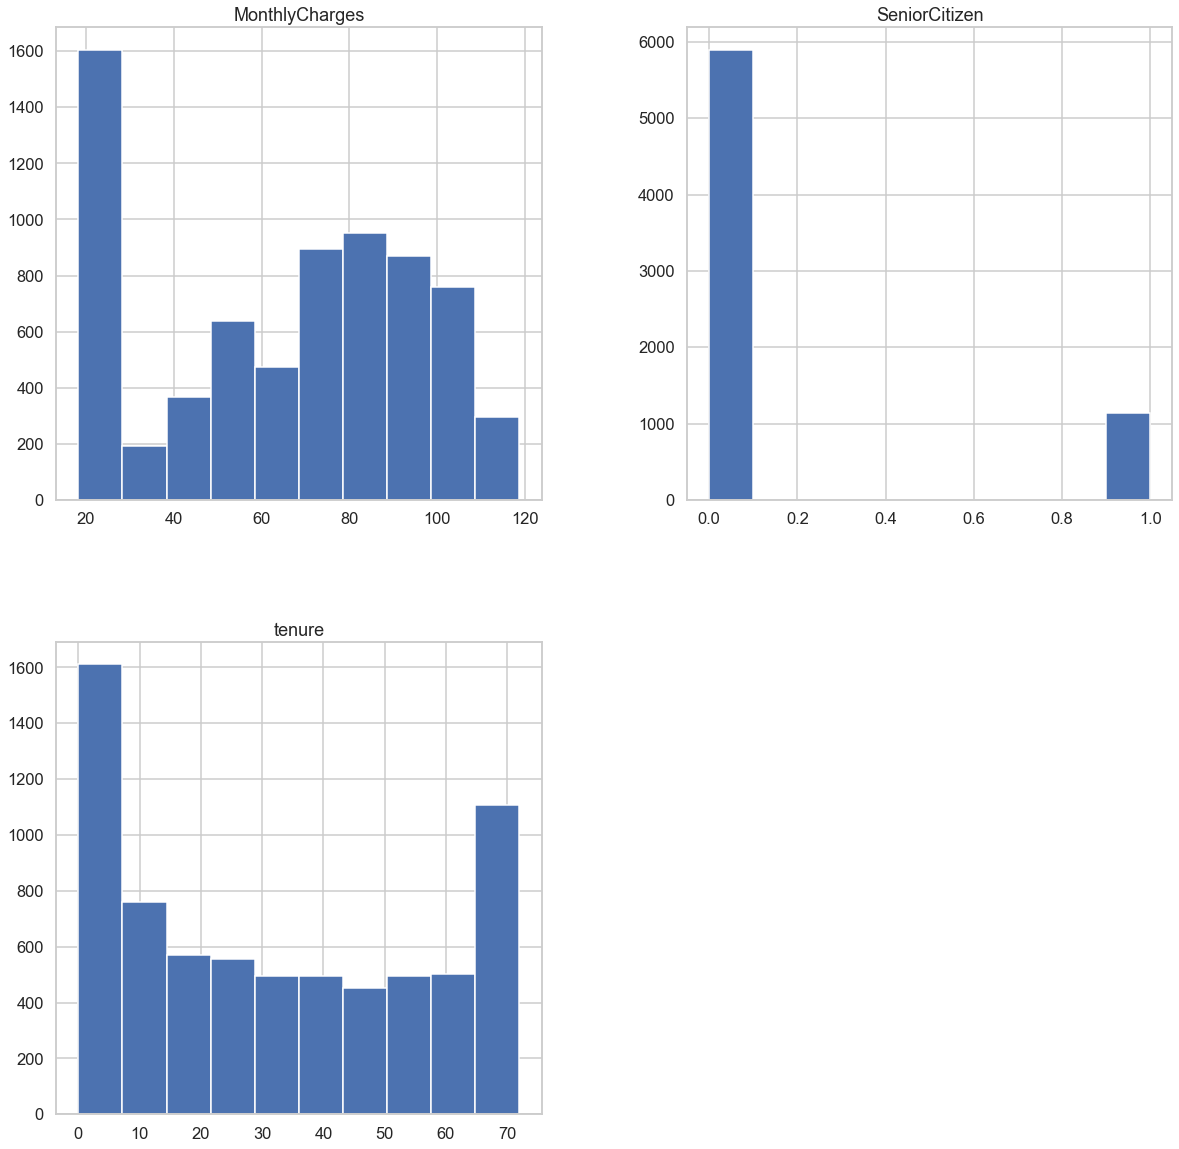

In [1556]:
statistics(original_df, check_na=True)

In [17]:
df = original_df.copy(deep=True)

## Drop columns

In [18]:
df.drop(['customerID'], axis=1, inplace=True)

In [313]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [19]:
cat = ['gender',              
'Partner',
'Dependents',          
'PhoneService',       
'MultipleLines',   
'InternetService',
'OnlineSecurity',
'OnlineBackup',
'DeviceProtection', 
'TechSupport', 
'StreamingTV',  
'StreamingMovies', 
'Contract',   
'PaperlessBilling',
'PaymentMethod', ]
df[cat].astype('category')

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic)
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check
7039,Female,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic)
7040,Female,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check
7041,Male,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check


VIF analysis not possible at the moment. Please fix dtypes of columns.
Shape:  (7043, 20)

dtype objects of each column and number of non-null objects:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
To

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


Int64Index([ 964, 1338, 1491, 1739, 1932, 2713, 2892, 3301, 3754, 4098, 4476,
            5506, 5736, 5759, 6267, 6499, 6518, 6609, 6706, 6764, 6774, 6924],
           dtype='int64')

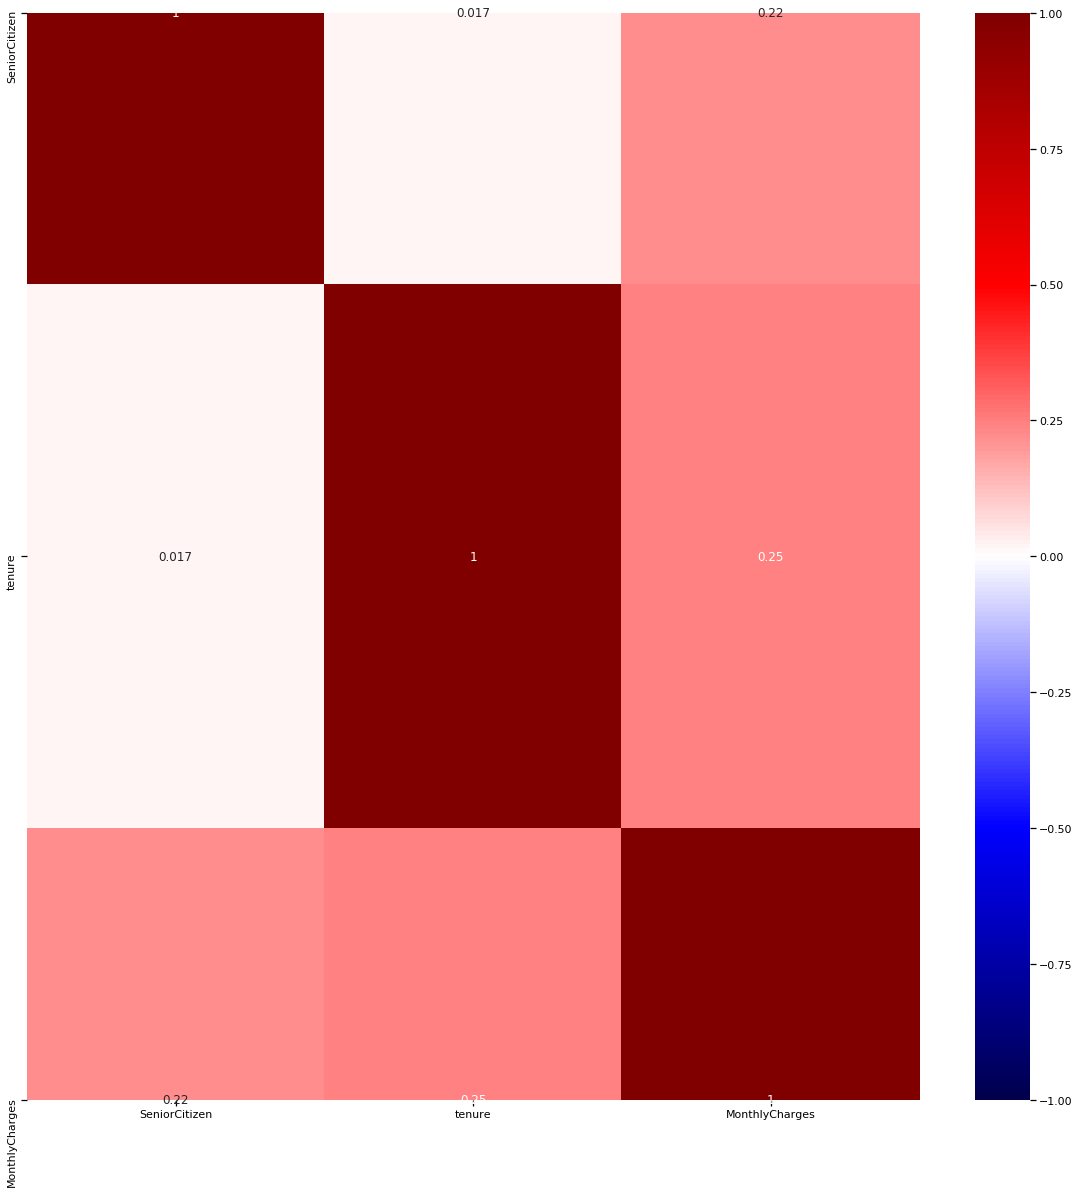

<Figure size 1440x1440 with 0 Axes>

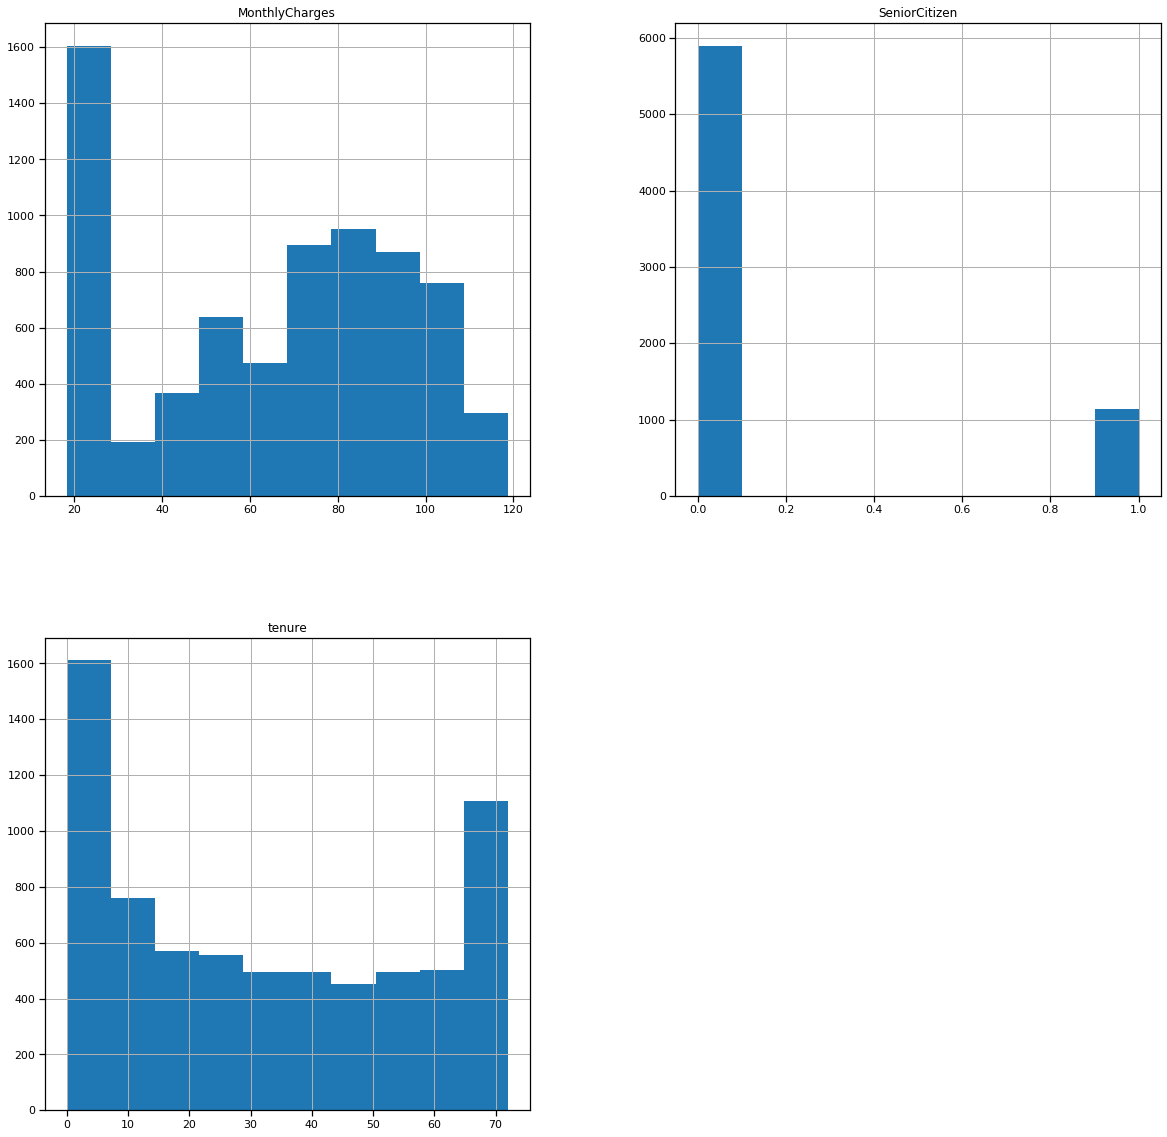

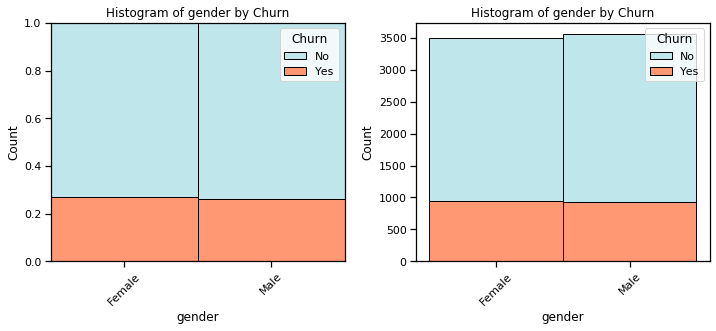

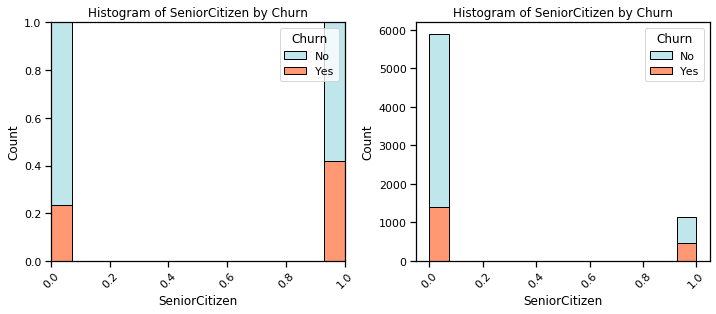

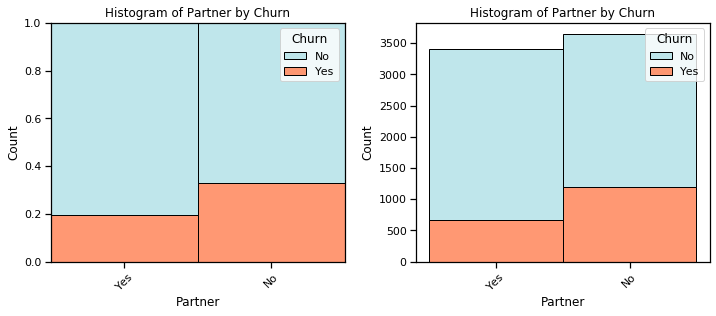

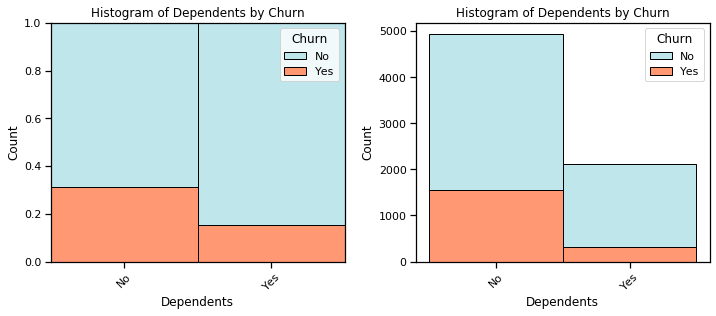

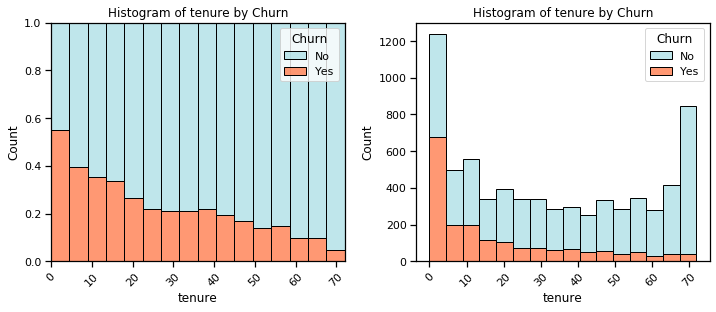

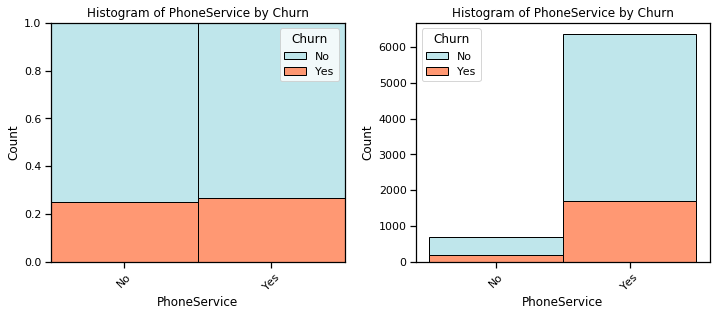

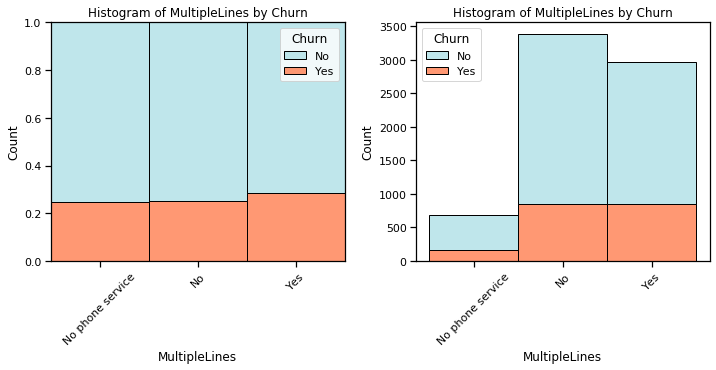

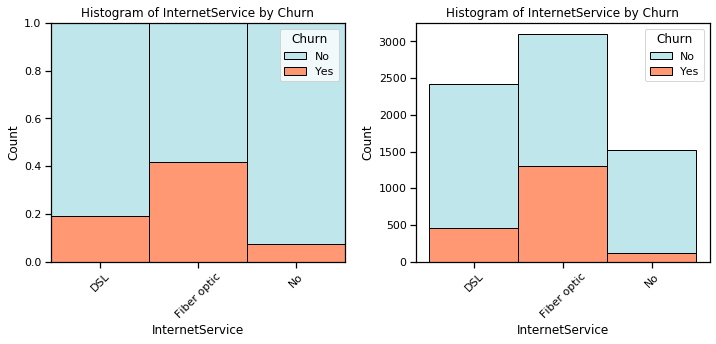

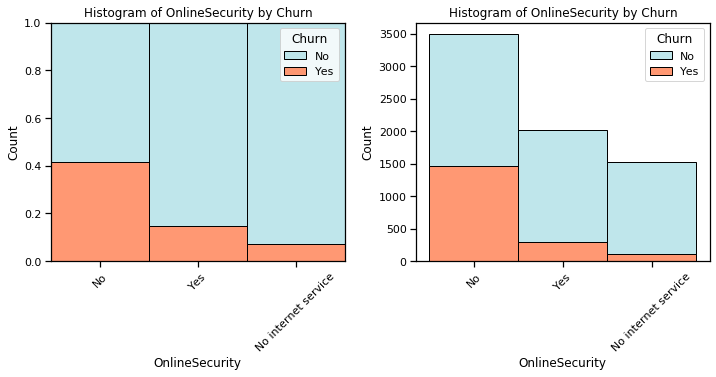

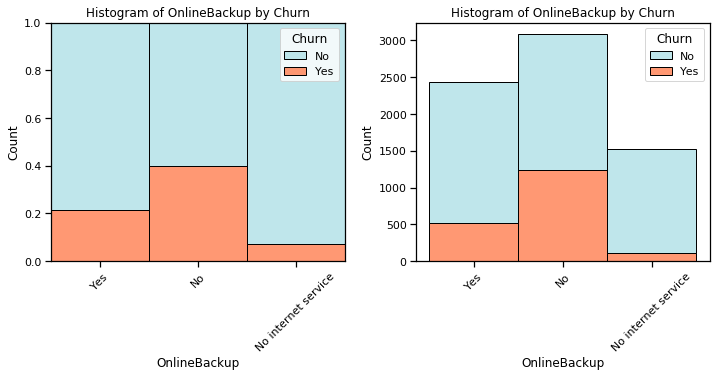

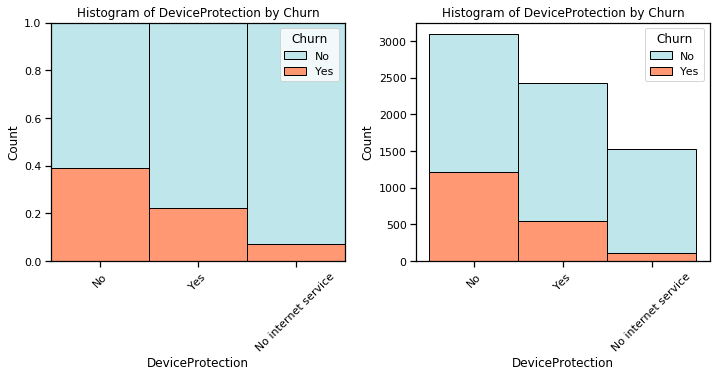

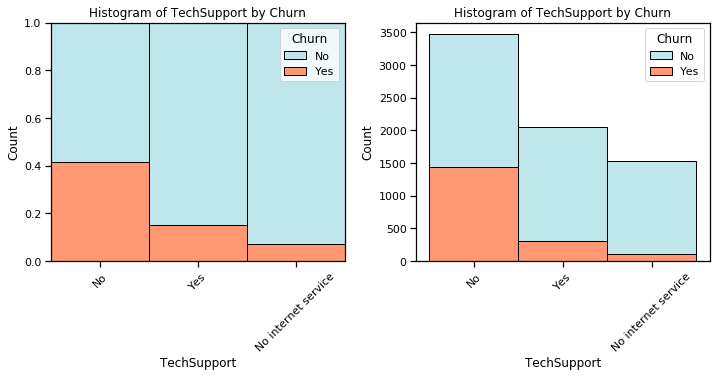

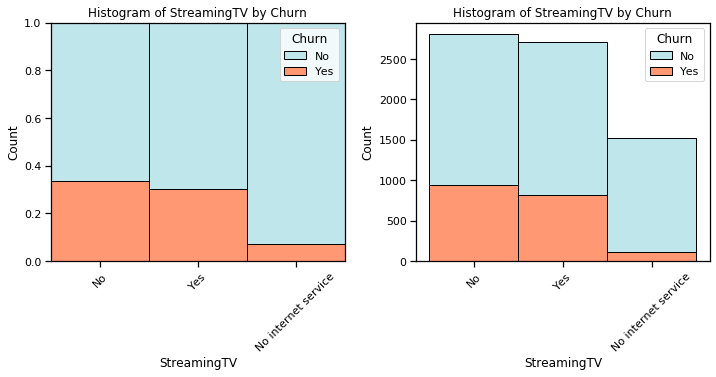

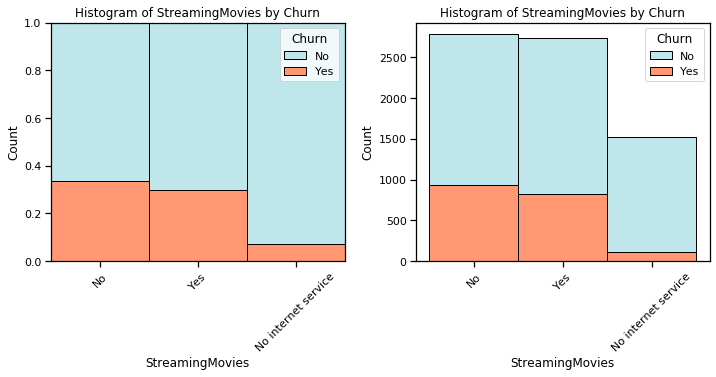

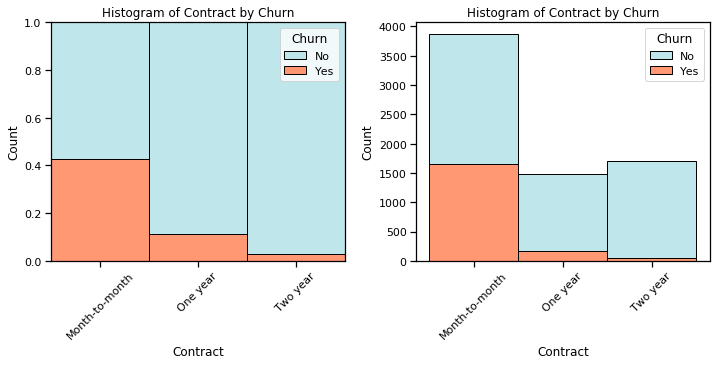

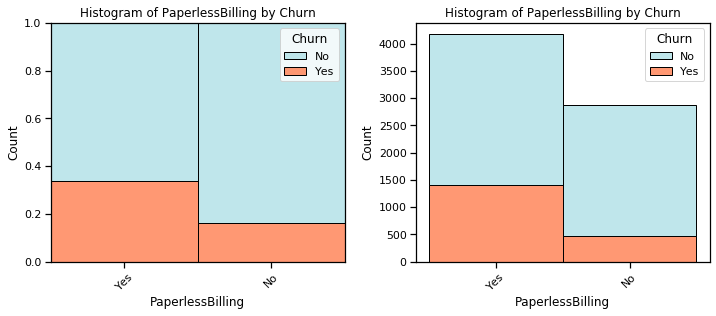

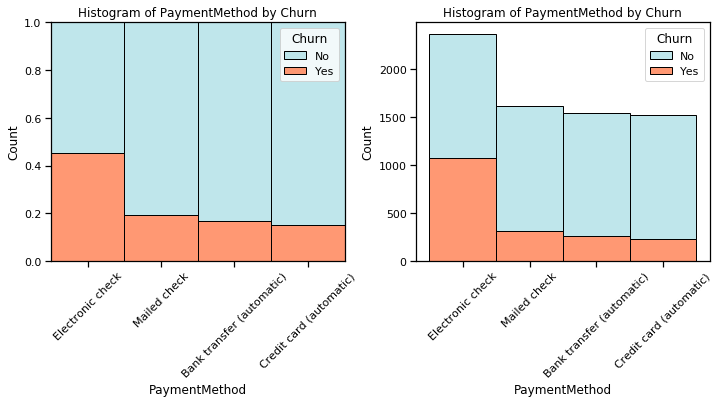

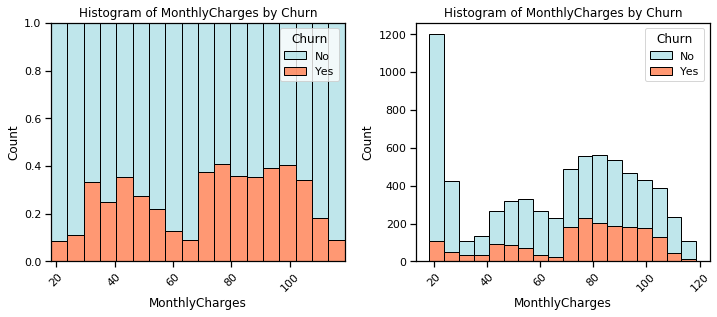

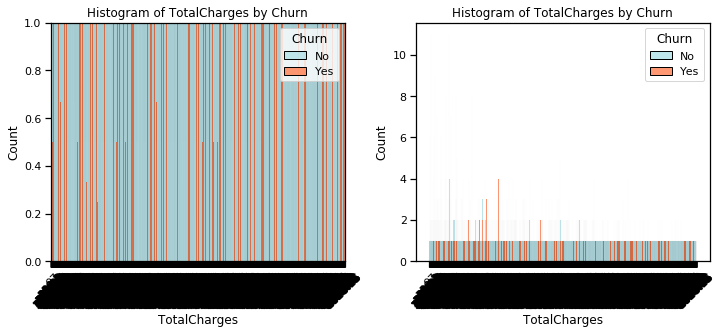

In [22]:
statistics(df, target='Churn')

In [20]:
#distribution of target variable
df['Churn'].value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

**Observations**

The classes are:
    - imbalanced: ~26% positive (churn=yes); ~74% negative (churn=no)
    - 'TotalCharges' is object type. It must be converted to float
    - No NaNs. Possible NaNs in other forms
    - Categorical variables to be converted as dummy variables for EDA and modelling 
    - Continous variables to be standardised
    - VIF must be evaluated (dummy variables necessary)
    - Churn rate is higher for: 
        - Tenure is low (churn happens in the first months)
        - SeniorCitizen == 0 (no senior citizen)
        - Partner == 0 (no partner) 
        - Dependents == 0 (no dependents) 
        - InternetService == 'Fiber Optic'
        - OnlineSecurity == No
        - OnlineBackup == No
        - DeviceProtection == No
        - TechSupport == No
        - PaperlessBilling == Yes
        - Contract == MonthToMonth
        - PaymentMethod == Electronic Check
        - MonthlyCharges > 70
    - Churn rate is lower for:
        - NoInternetService == True

## Strategy

- EDA after dtype fixing
- VIF analysis and feature selection
- RandomSearch to get most promising model
- GridSearch to fine tune best model
- Feature importance
- Oversampling and undersampling;

Measure to maximise:
- Recall for predicting churning

Assessment:
- Confusion matrix
- ROC curve + AUC
- Precision-Recall curve
- Brier score

## Fixing dtypes

TotalCharges is an "object" dtype. We need to turn it into float.

In [24]:
#check where TotalCharges == ' ', aka missing value
df.loc[df['TotalCharges'] == ' ',:], len(df.loc[df['TotalCharges'] == ' ',:])

(      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 488   Female              0     Yes        Yes       0           No   
 753     Male              0      No        Yes       0          Yes   
 936   Female              0     Yes        Yes       0          Yes   
 1082    Male              0     Yes        Yes       0          Yes   
 1340  Female              0     Yes        Yes       0           No   
 3331    Male              0     Yes        Yes       0          Yes   
 3826    Male              0     Yes        Yes       0          Yes   
 4380  Female              0     Yes        Yes       0          Yes   
 5218    Male              0     Yes        Yes       0          Yes   
 6670  Female              0     Yes        Yes       0          Yes   
 6754    Male              0      No        Yes       0          Yes   
 
          MultipleLines InternetService       OnlineSecurity  \
 488   No phone service             DSL                  Yes   
 753  

To define strategy to fill NaNs, get statistics about the dataset when 'TotalCharges' == ' '.
Confront the values with the dataset values for the complementary  of the condition above.

VIF analysis not possible at the moment. Please fix dtypes of columns.
Shape:  (11, 20)

dtype objects of each column and number of non-null objects:


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 488 to 6754
Data columns (total 20 columns):
gender              11 non-null object
SeniorCitizen       11 non-null int64
Partner             11 non-null object
Dependents          11 non-null object
tenure              11 non-null int64
PhoneService        11 non-null object
MultipleLines       11 non-null object
InternetService     11 non-null object
OnlineSecurity      11 non-null object
OnlineBackup        11 non-null object
DeviceProtection    11 non-null object
TechSupport         11 non-null object
StreamingTV         11 non-null object
StreamingMovies     11 non-null object
Contract            11 non-null object
PaperlessBilling    11 non-null object
PaymentMethod       11 non-null object
MonthlyCharges      11 non-null float64
TotalCharges        11 non-null object
C

Int64Index([], dtype='int64')

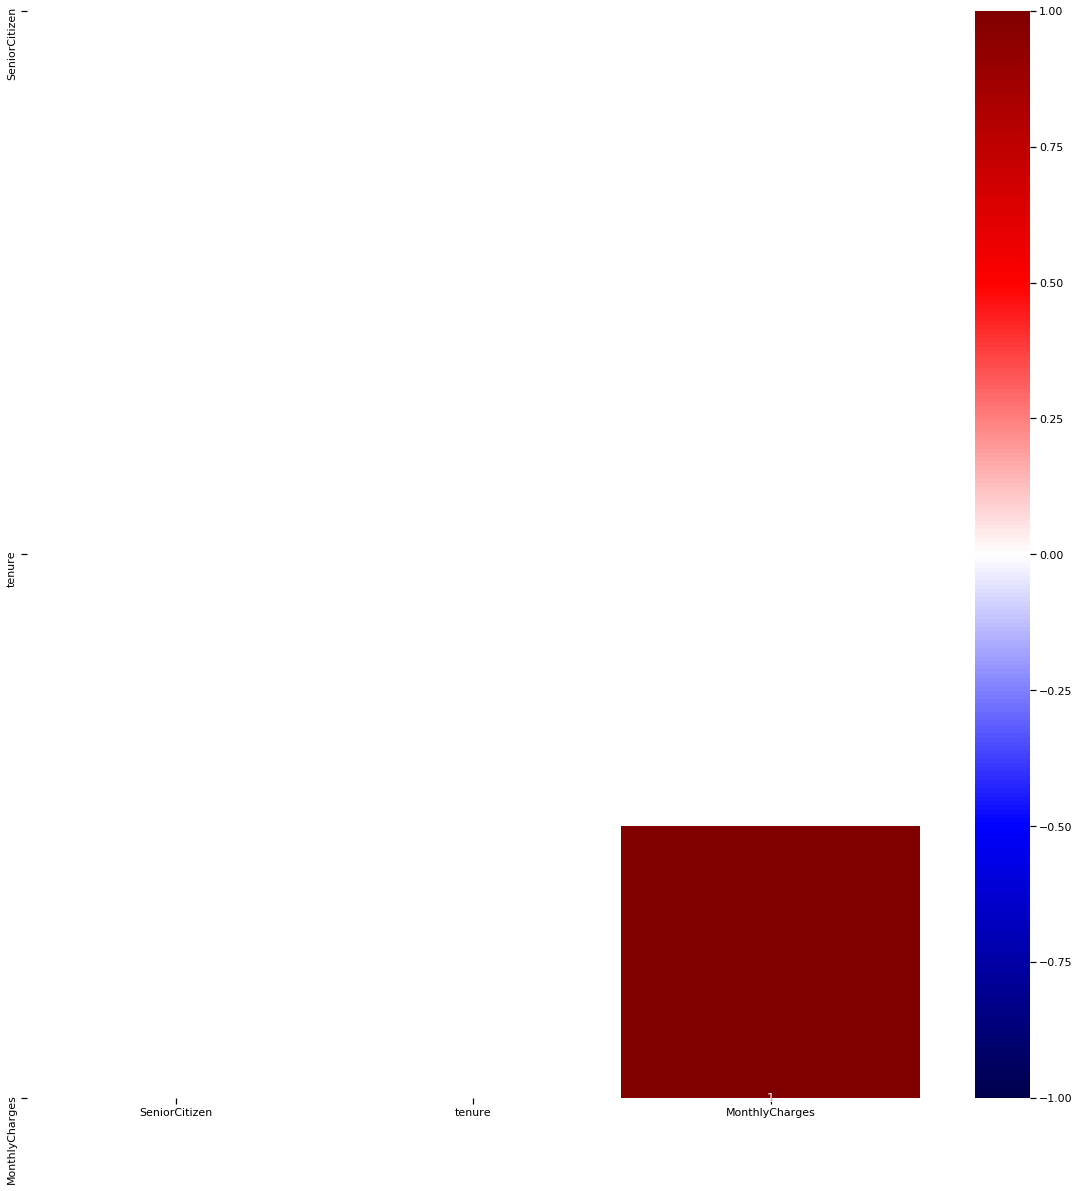

<Figure size 1440x1440 with 0 Axes>

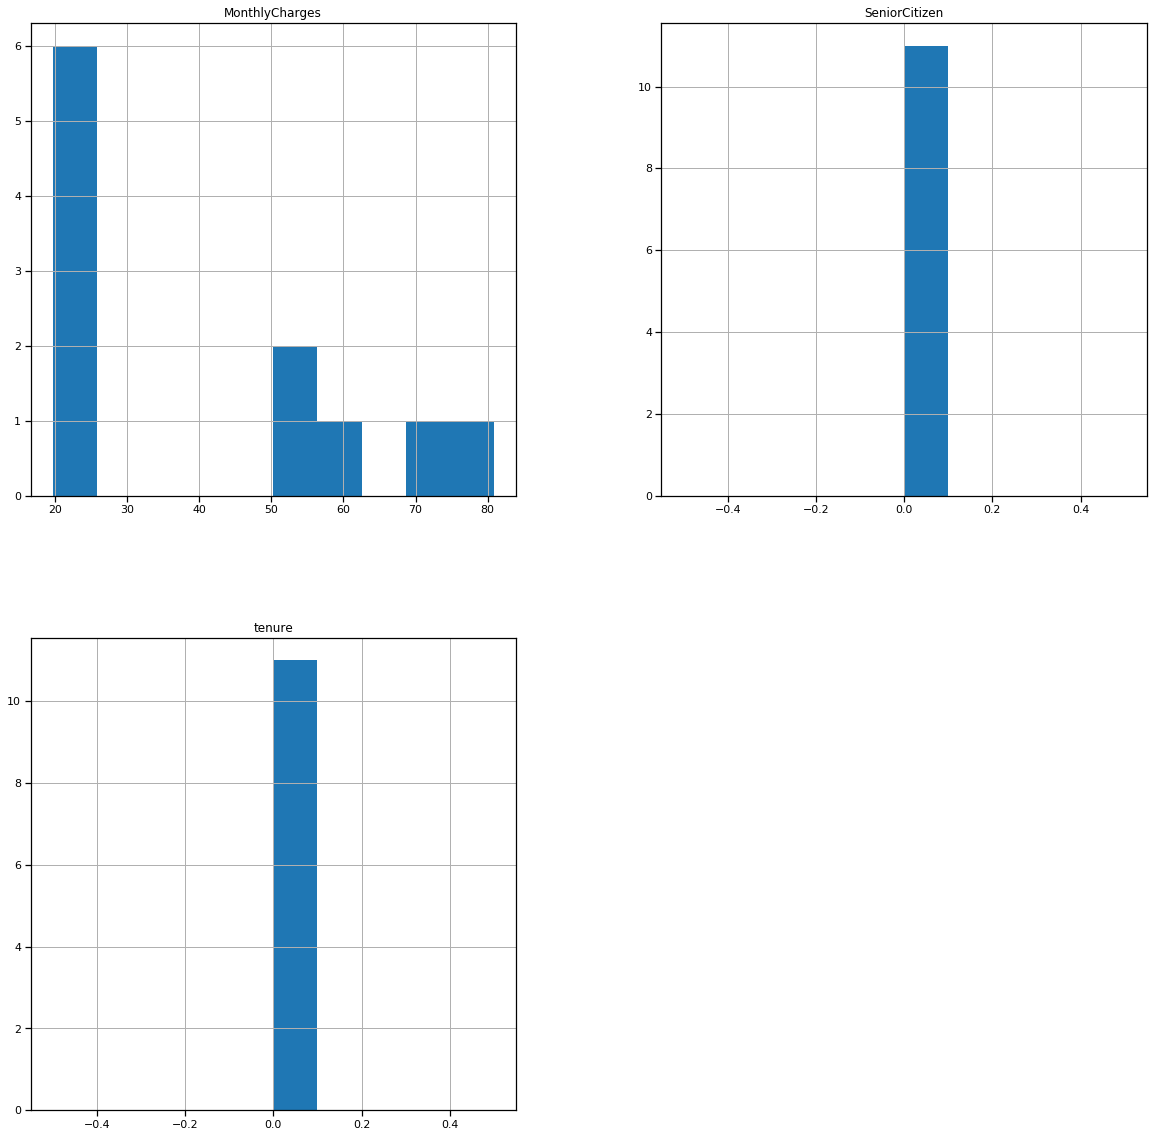

In [25]:
statistics(df.loc[df['TotalCharges'] == ' ',:])

VIF analysis not possible at the moment. Please fix dtypes of columns.
Shape:  (7032, 20)

dtype objects of each column and number of non-null objects:


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
tenure              7032 non-null int64
PhoneService        7032 non-null object
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
To

Int64Index([ 964, 1338, 1491, 1739, 1932, 2713, 2892, 3301, 3754, 4098, 4476,
            5506, 5736, 5759, 6267, 6499, 6518, 6609, 6706, 6764, 6774, 6924],
           dtype='int64')

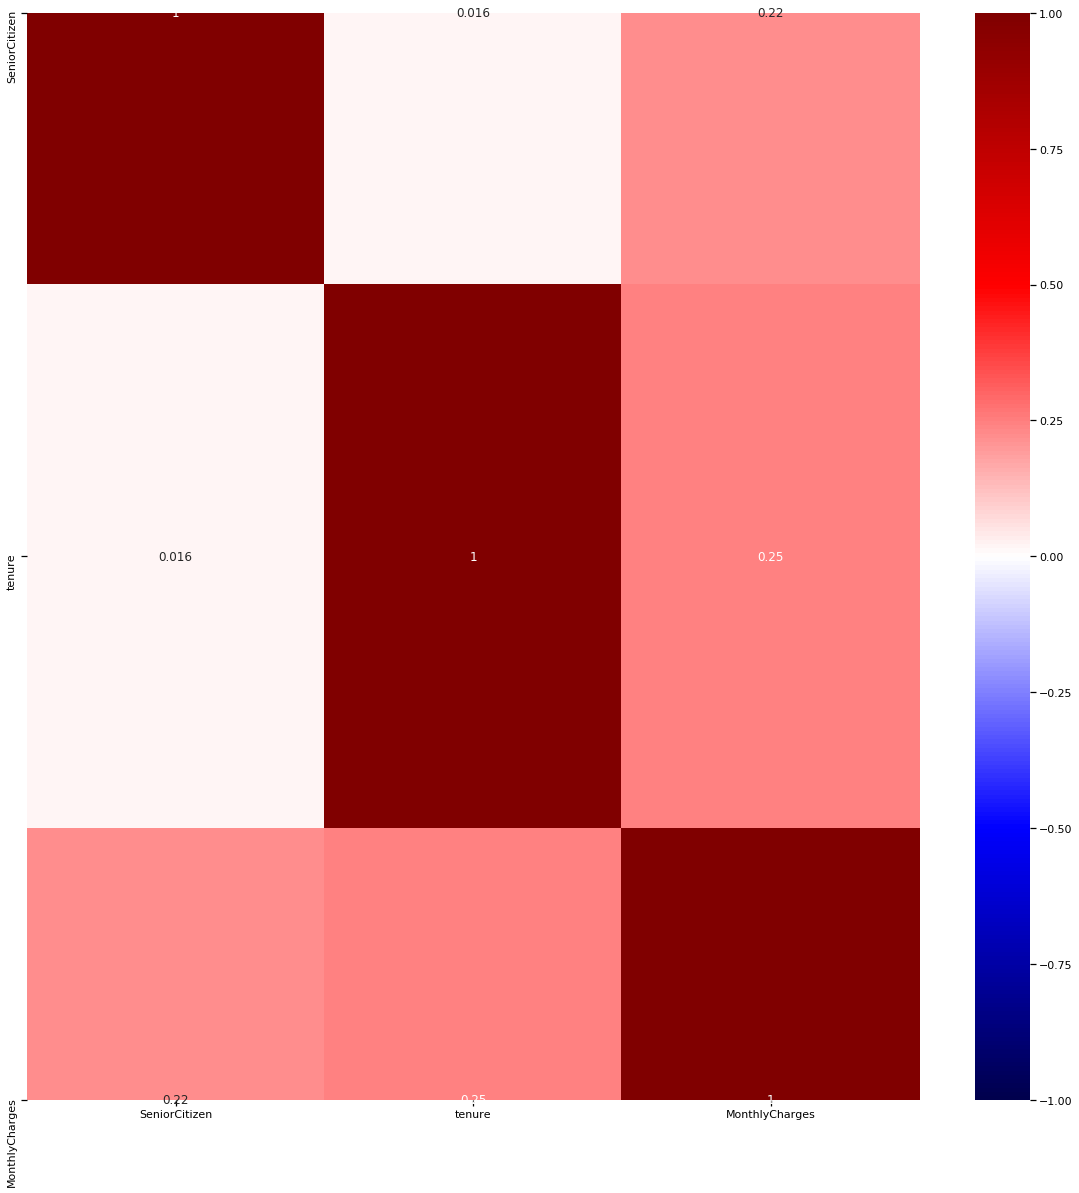

<Figure size 1440x1440 with 0 Axes>

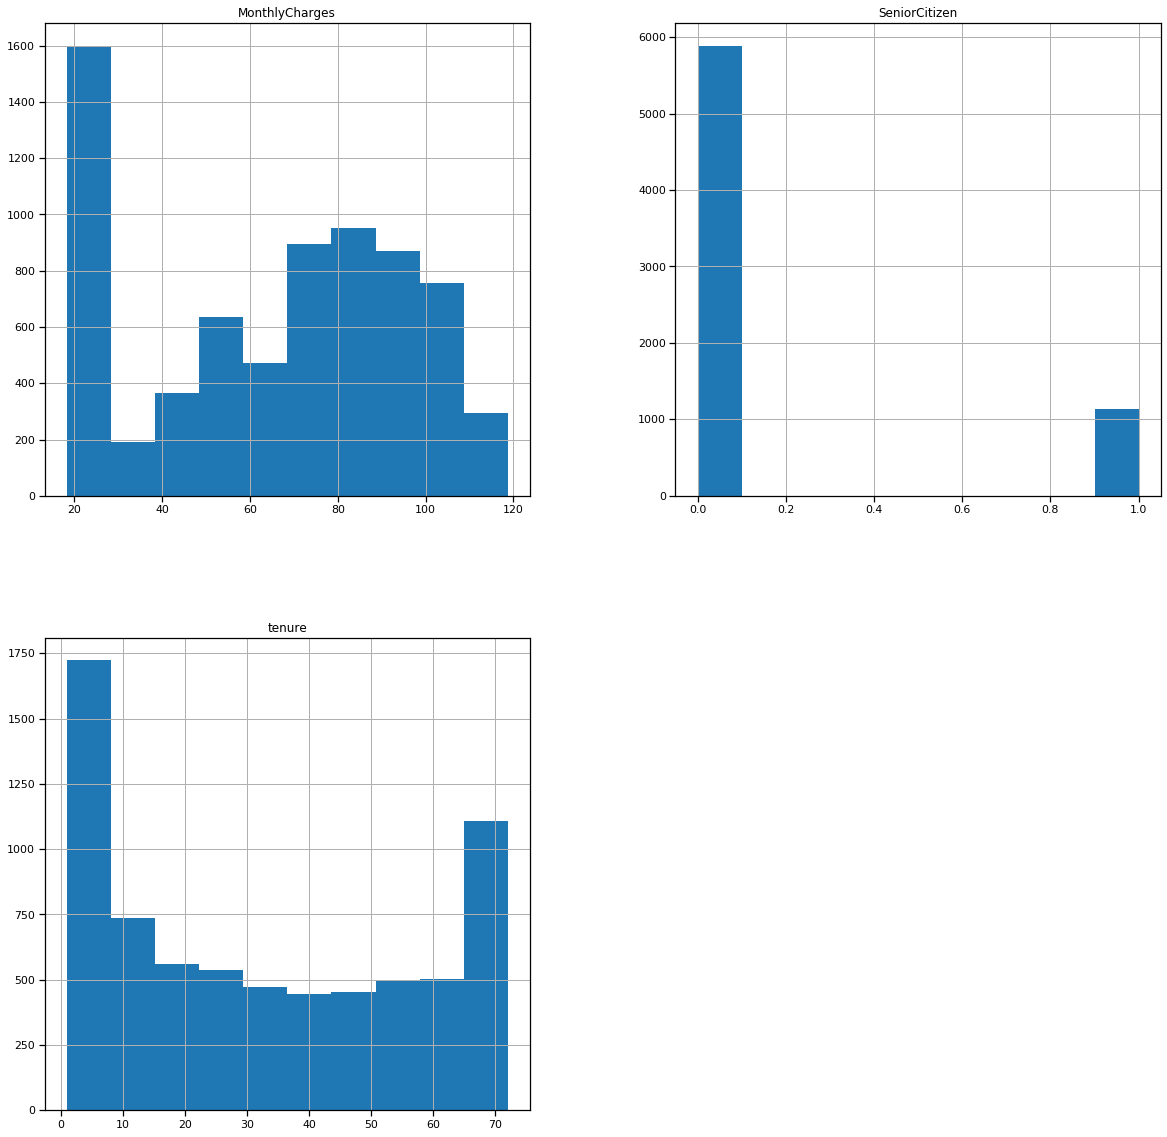

In [26]:
statistics(df.loc[~(df['TotalCharges'] == ' '),:])

'Tenure' == 0 for rows where 'TotalCharges' == ' '. Being only 11 rows, we opt to drop them.

In [21]:
df_pre = df.loc[~(df['TotalCharges'] == ' '),:]
df_pre['TotalCharges'] = df_pre['TotalCharges'].astype(float)
df_pre = df_pre.drop('Churn', axis=1)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
df_dum = pd.get_dummies(df_pre, drop_first=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


            vif                               features
11          inf                     InternetService_No
12          inf     OnlineSecurity_No internet service
20          inf        StreamingTV_No internet service
18          inf        TechSupport_No internet service
16          inf   DeviceProtection_No internet service
14          inf       OnlineBackup_No internet service
22          inf    StreamingMovies_No internet service
7   1773.528816                       PhoneService_Yes
2    866.089640                         MonthlyCharges
10   148.500814            InternetService_Fiber optic
8     60.842267         MultipleLines_No phone service
23    24.156394                    StreamingMovies_Yes
21    24.080019                        StreamingTV_Yes
3     10.811490                           TotalCharges
1      7.584453                                 tenure
9      7.289761                      MultipleLines_Yes
17     6.924754                   DeviceProtection_Yes
15     6.7

Duplicated rows in the dataframe:  40 Indexes where duplicated Int64Index([ 964, 1338, 1491, 1739, 1932, 2713, 2892, 2927, 3301, 3499, 3675,
            3754, 4065, 4098, 4131, 4172, 4476, 4564, 4721, 4789, 4817, 5170,
            5480, 5506, 5662, 5705, 5736, 5738, 5759, 5908, 6267, 6388, 6449,
            6499, 6518, 6609, 6706, 6764, 6774, 6924],
           dtype='int64')
List of columns in the dataframe:
Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',


Int64Index([ 964, 1338, 1491, 1739, 1932, 2713, 2892, 2927, 3301, 3499, 3675,
            3754, 4065, 4098, 4131, 4172, 4476, 4564, 4721, 4789, 4817, 5170,
            5480, 5506, 5662, 5705, 5736, 5738, 5759, 5908, 6267, 6388, 6449,
            6499, 6518, 6609, 6706, 6764, 6774, 6924],
           dtype='int64')

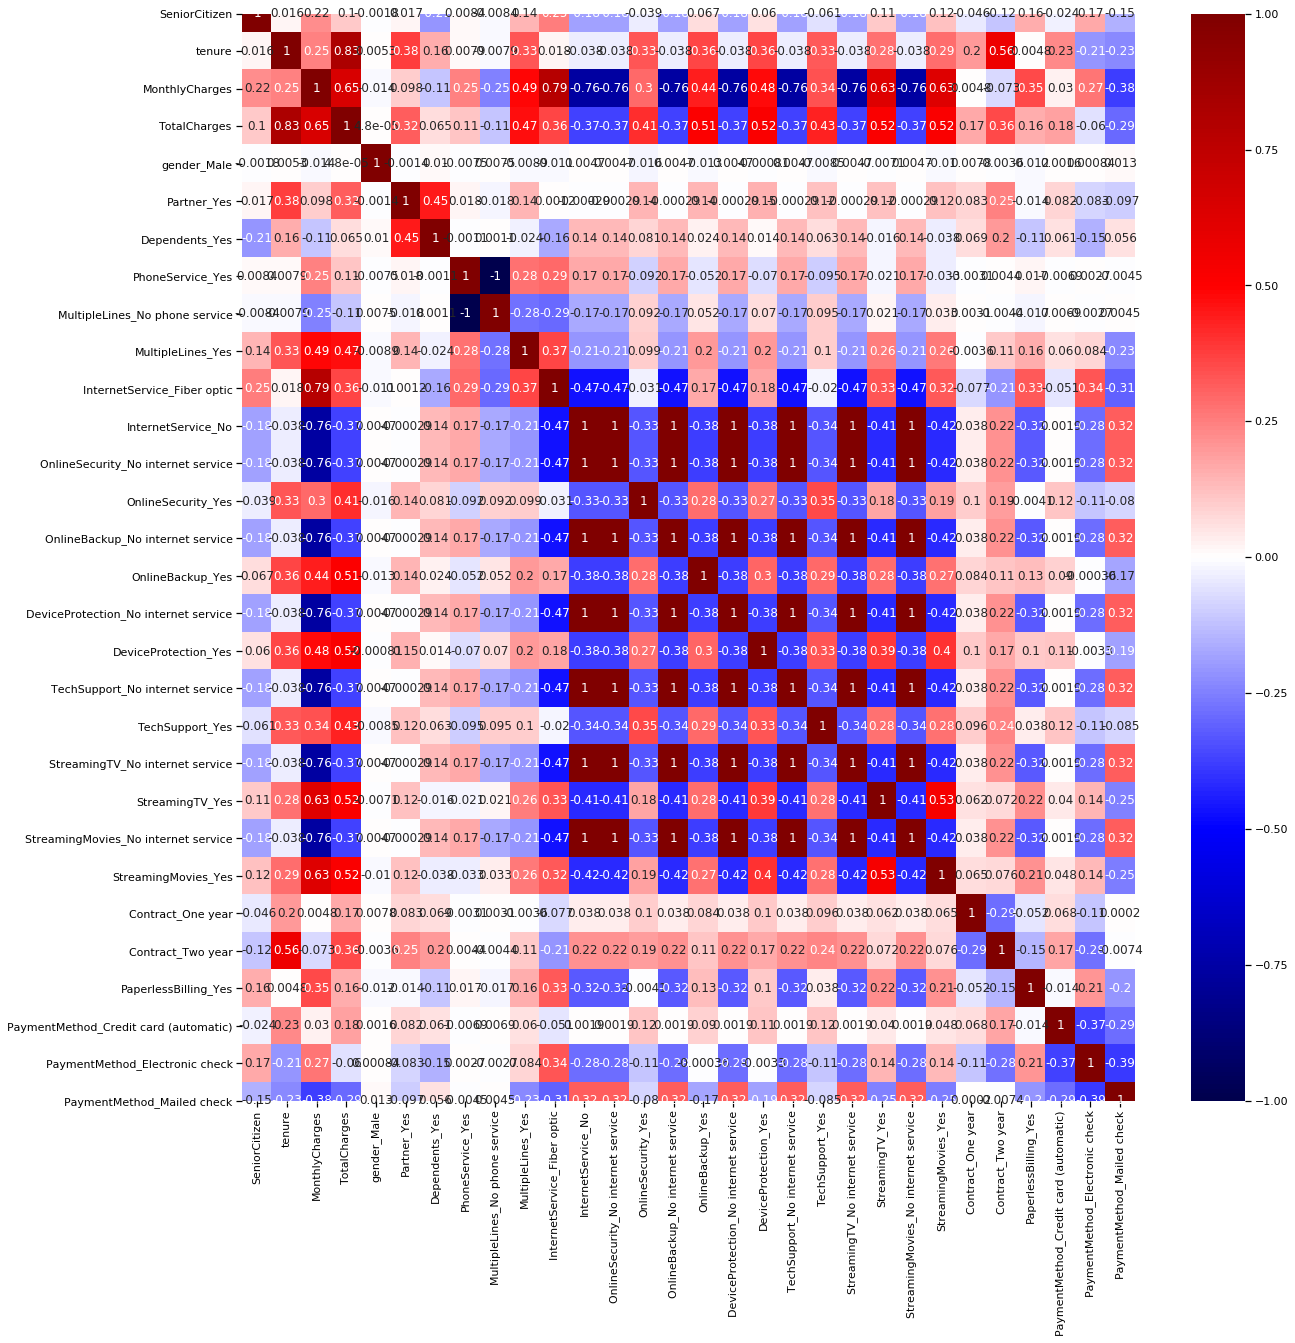

<Figure size 1440x1440 with 0 Axes>

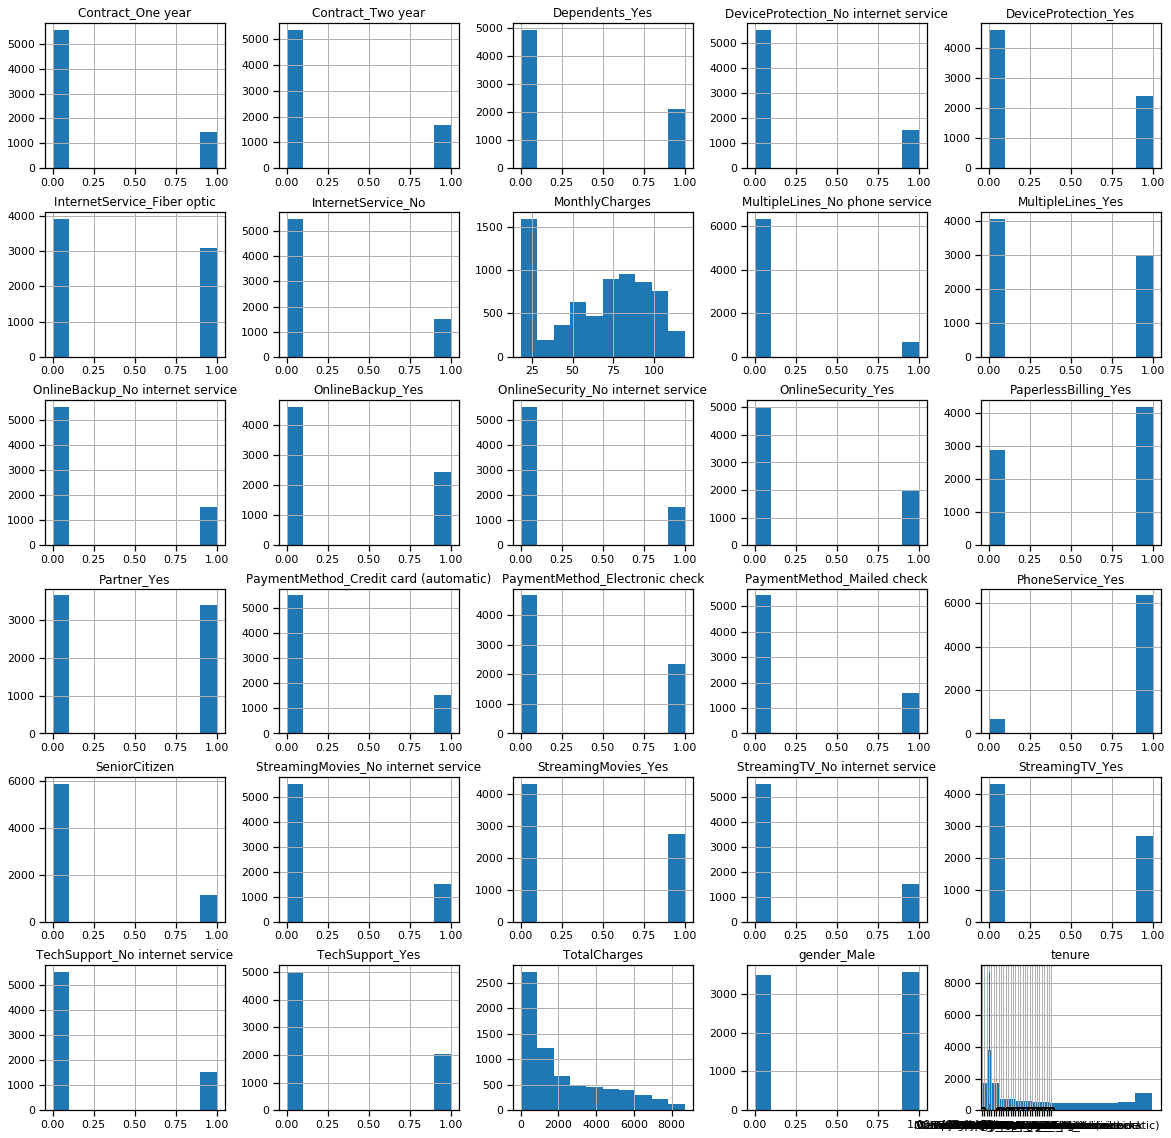

In [30]:
statistics(df_dum)

In [23]:
'''TechSupport_No internet service
22          inf    StreamingMovies_No internet service
16          inf   DeviceProtection_No internet service
11          inf                     InternetService_No
12          inf     OnlineSecurity_No internet service
20          inf        StreamingTV_No internet service
14          inf       OnlineBackup_No internet service
7   1774.603920                       PhoneService_Yes
2    866.100958                         MonthlyCharges
10   148.578927            InternetService_Fiber optic
8     60.960500         MultipleLines_No phone service
23    24.163746                    StreamingMovies_Yes
21    24.086910                        StreamingTV_Yes'''

to_drop = ['StreamingMovies_No internet service', 'DeviceProtection_No internet service', 'InternetService_No', 'OnlineSecurity_No internet service', 'StreamingTV_No internet service', 'OnlineBackup_No internet service', 'PhoneService_Yes']




In [ ]:
statistics(df_dum.drop(to_drop, axis=1))

In [24]:
to_drop.append('TotalCharges')

          vif                               features
2   40.857082                         MonthlyCharges
1    7.761093                                 tenure
8    7.645319            InternetService_Fiber optic
17   3.463146                      Contract_Two year
15   3.055100                    StreamingMovies_Yes
14   2.993866                        StreamingTV_Yes
20   2.966177         PaymentMethod_Electronic check
18   2.963012                   PaperlessBilling_Yes
4    2.825129                            Partner_Yes
7    2.637310                      MultipleLines_Yes
12   2.618428        TechSupport_No internet service
11   2.385763                   DeviceProtection_Yes
21   2.375199             PaymentMethod_Mailed check
13   2.268022                        TechSupport_Yes
10   2.254965                       OnlineBackup_Yes
9    2.179070                     OnlineSecurity_Yes
16   2.056071                      Contract_One year
3    2.022589                            gende

Int64Index([ 964, 1338, 1491, 1739, 1932, 2713, 2892, 2927, 3301, 3391, 3499,
            3647, 3675, 3754, 4065, 4098, 4131, 4172, 4444, 4476, 4564, 4660,
            4721, 4789, 4797, 4817, 5024, 5170, 5480, 5506, 5529, 5662, 5705,
            5736, 5738, 5759, 5908, 6267, 6388, 6449, 6499, 6518, 6609, 6706,
            6764, 6774, 6875, 6924],
           dtype='int64')

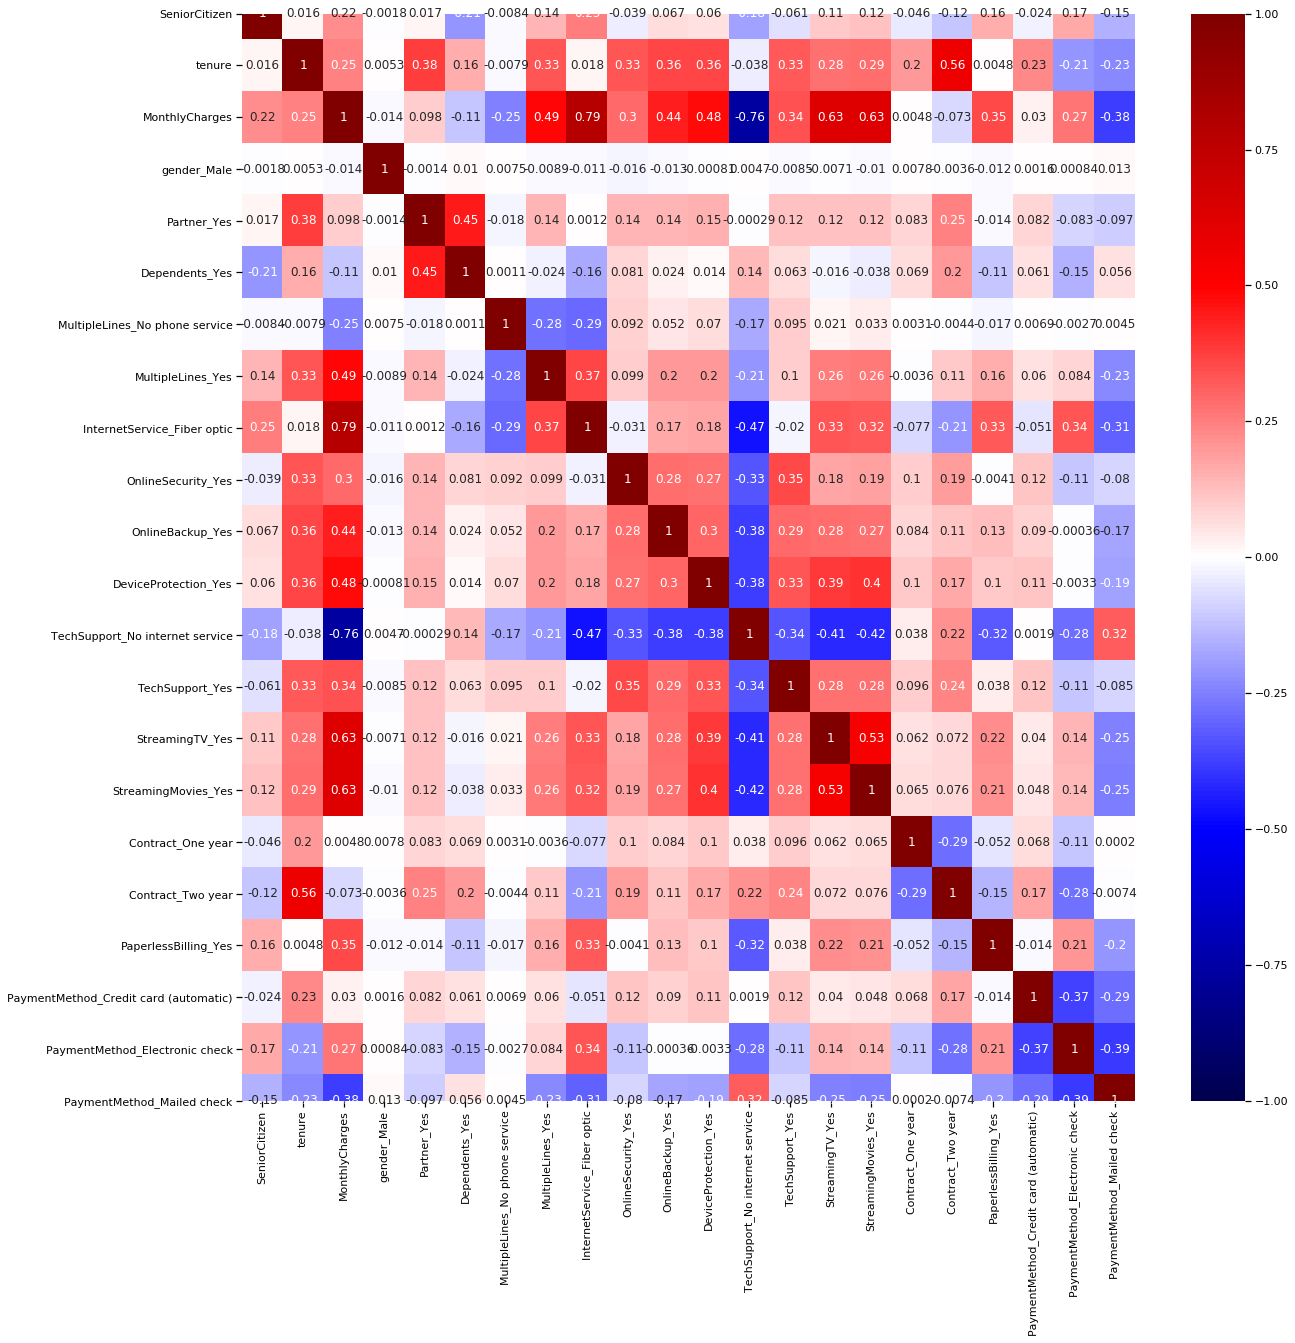

<Figure size 1440x1440 with 0 Axes>

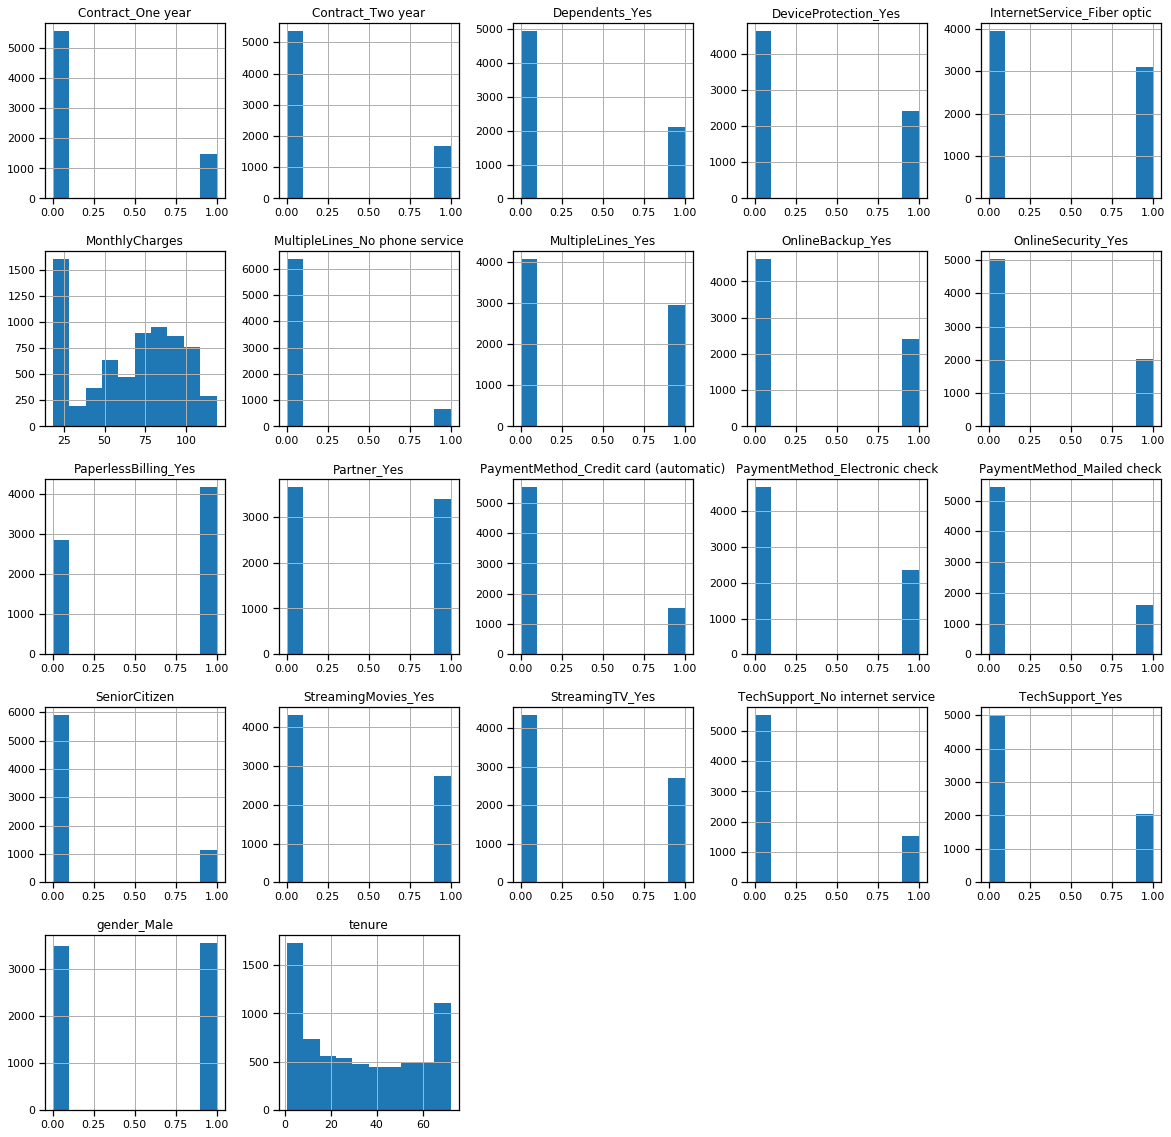

In [33]:
statistics(df_dum.drop(to_drop, axis=1))

In [25]:
to_drop.append('InternetService_Fiber optic')

          vif                               features
2   16.997688                         MonthlyCharges
1    7.756609                                 tenure
16   3.452483                      Contract_Two year
17   2.937935                   PaperlessBilling_Yes
14   2.930448                    StreamingMovies_Yes
13   2.885415                        StreamingTV_Yes
19   2.843399         PaymentMethod_Electronic check
4    2.823004                            Partner_Yes
7    2.614585                      MultipleLines_Yes
11   2.608207        TechSupport_No internet service
10   2.322747                   DeviceProtection_Yes
9    2.174315                       OnlineBackup_Yes
20   2.159762             PaymentMethod_Mailed check
12   2.056244                        TechSupport_Yes
15   2.041490                      Contract_One year
3    1.983792                            gender_Male
8    1.958737                     OnlineSecurity_Yes
5    1.955377                         Dependen

Int64Index([ 964, 1338, 1491, 1739, 1932, 2713, 2892, 2927, 3301, 3391, 3499,
            3647, 3675, 3754, 4065, 4098, 4131, 4172, 4444, 4476, 4564, 4660,
            4721, 4789, 4797, 4817, 5024, 5170, 5480, 5506, 5529, 5662, 5705,
            5736, 5738, 5759, 5908, 6267, 6388, 6449, 6499, 6518, 6609, 6706,
            6764, 6774, 6875, 6924],
           dtype='int64')

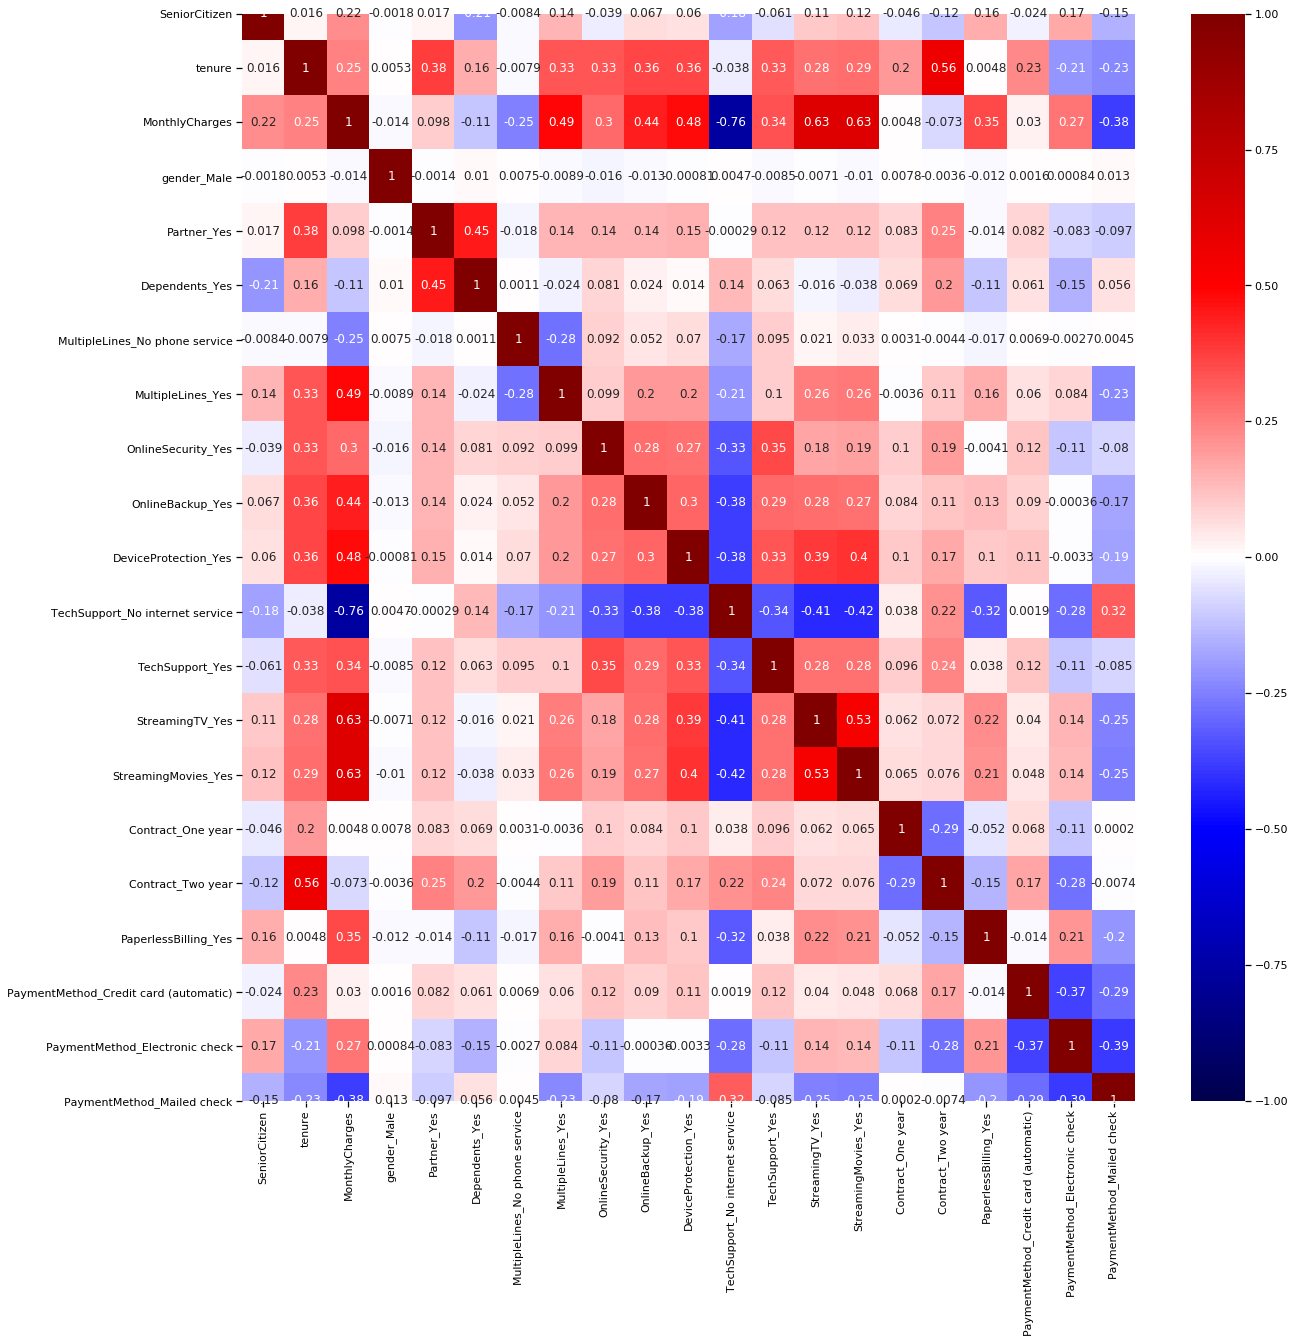

<Figure size 1440x1440 with 0 Axes>

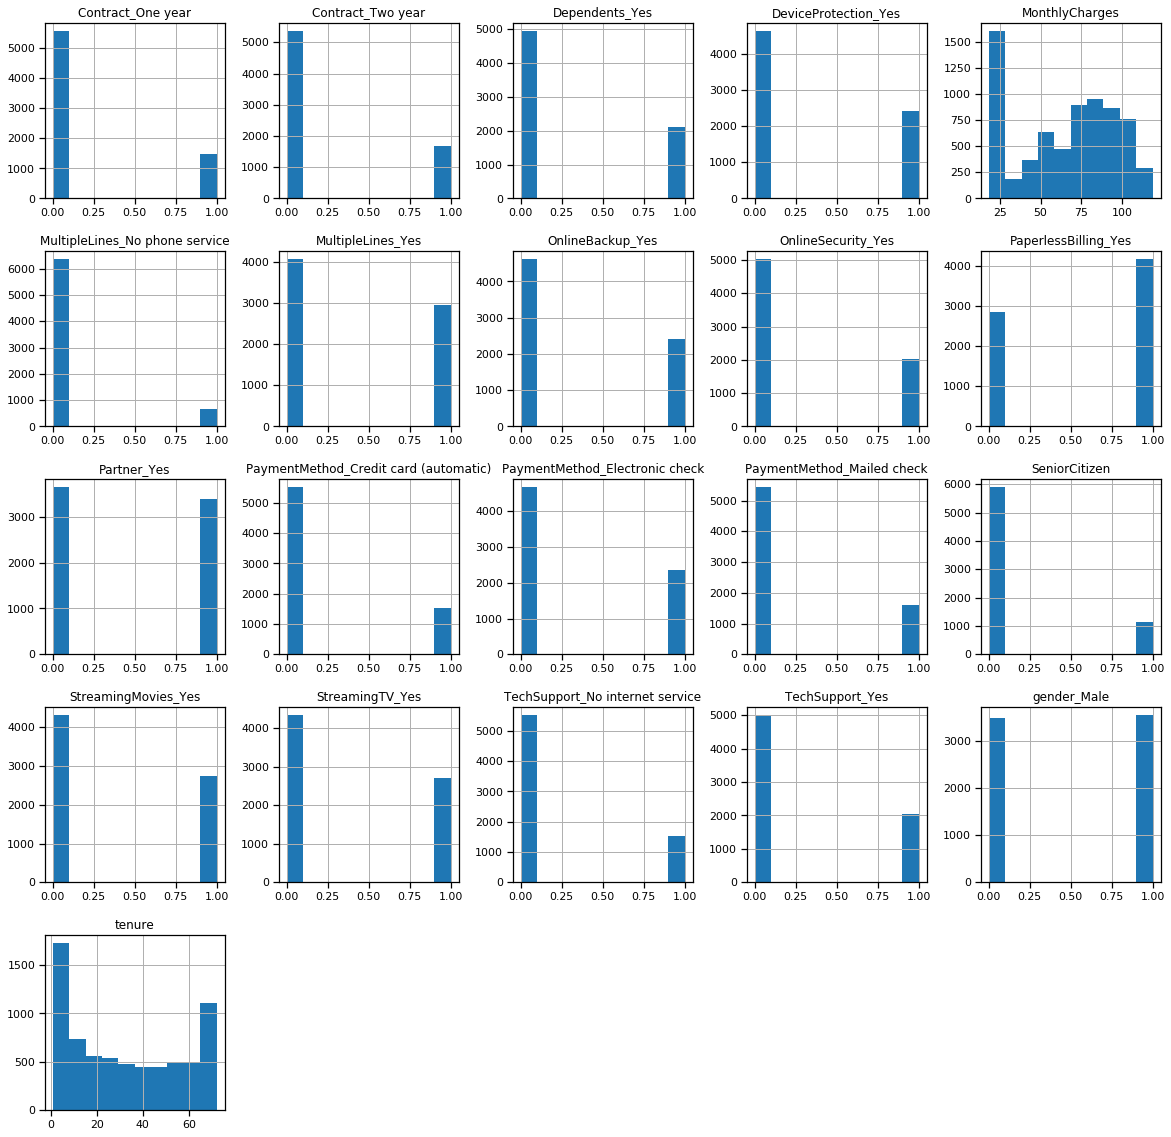

In [35]:
statistics(df_dum.drop(to_drop, axis=1))

In [26]:
X = df_pre
y = pd.DataFrame(df['Churn'][X.index], columns=['Churn'])

In [27]:
df_full = pd.concat([df_pre, y], axis=1)

In [604]:
os.chdir('../data/processed')

In [610]:
df_full.to_csv('telcom-dataset.csv',columns= df_full.columns, index=False)
df_dum.to_csv('telcom-dataset-dummies.csv', columns= df_dum.columns, index=False)

In [613]:
#pickle some objects to reuse in 'classification' notebook
with open('todrop.pkl', 'wb') as f:
    pickle.dump(to_drop, f)

with open('cat.pkl', 'wb') as f:
    pickle.dump(cat, f)

In [608]:
df_load = pd.read_csv('telcom-dataset.csv')
df_load.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


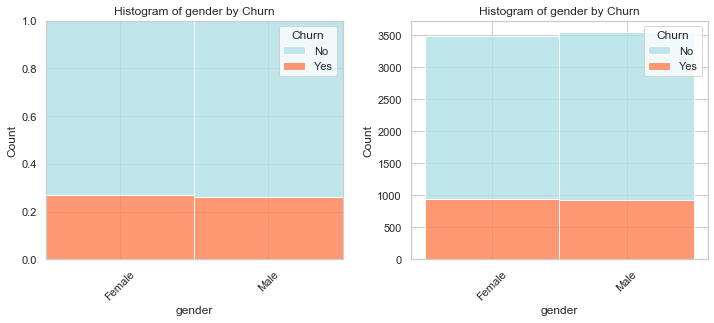

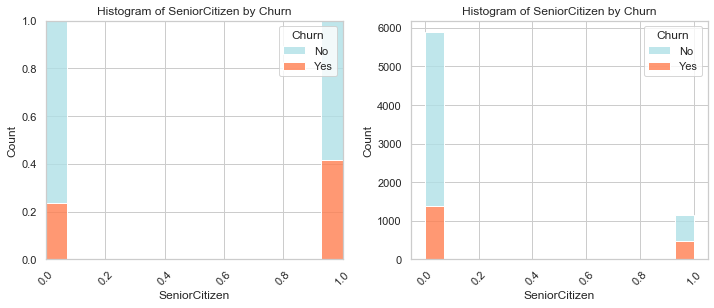

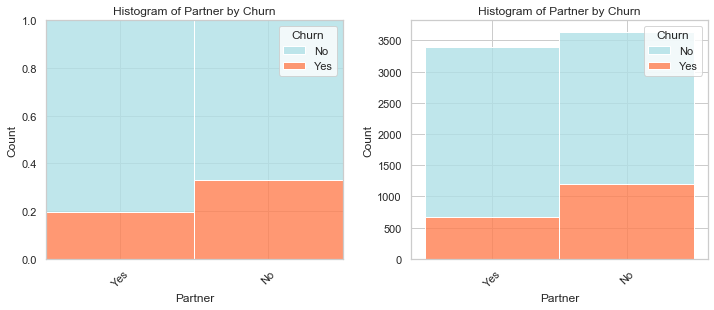

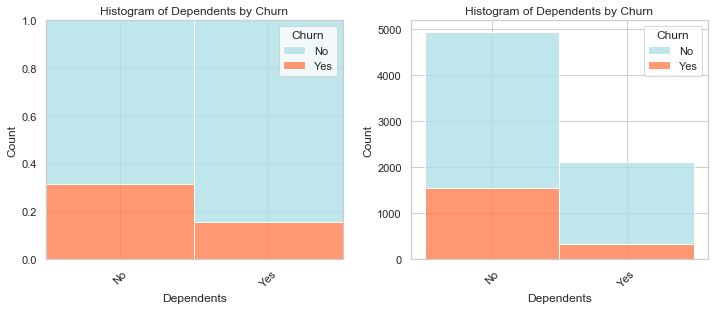

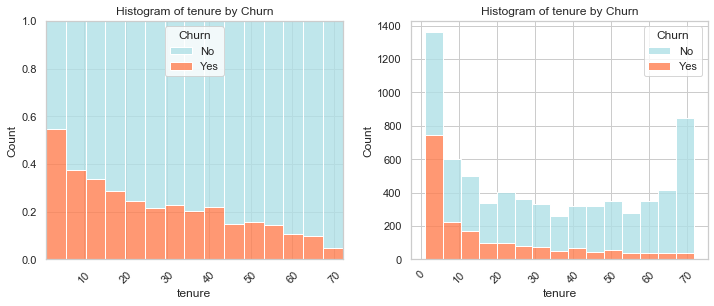

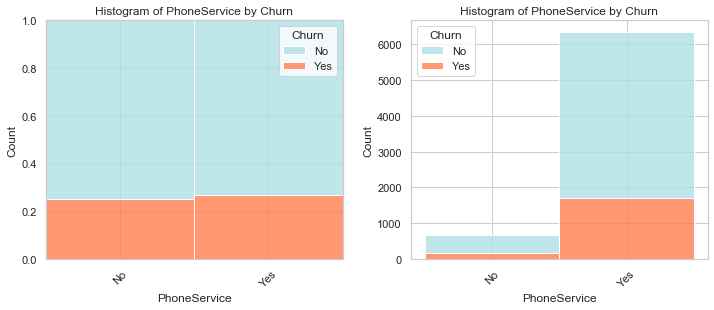

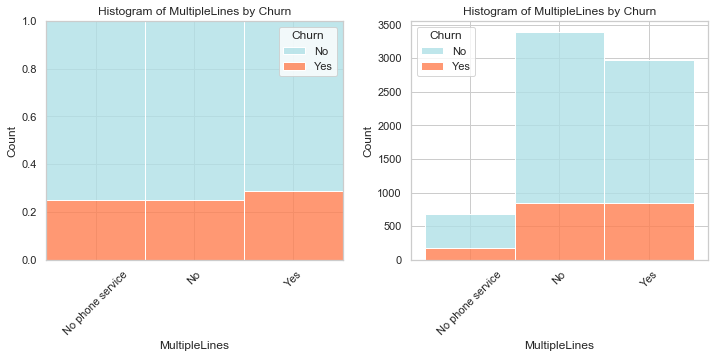

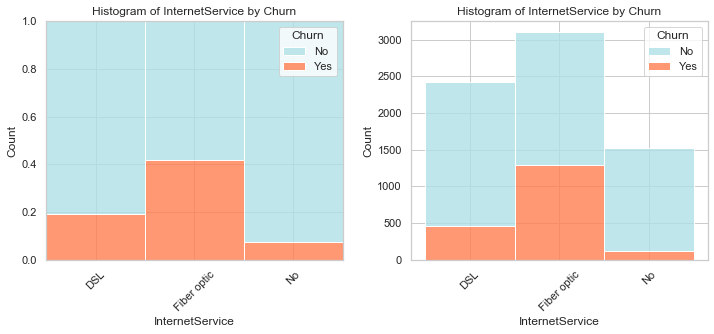

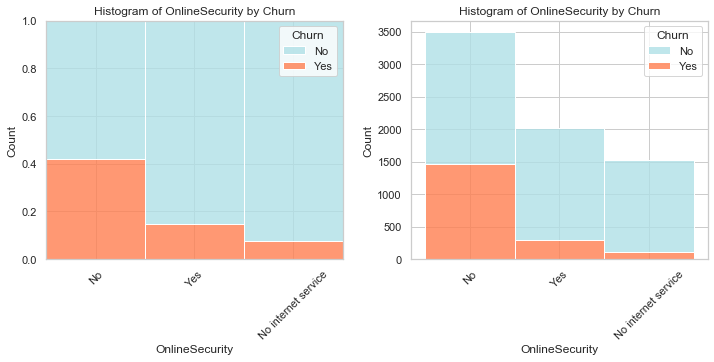

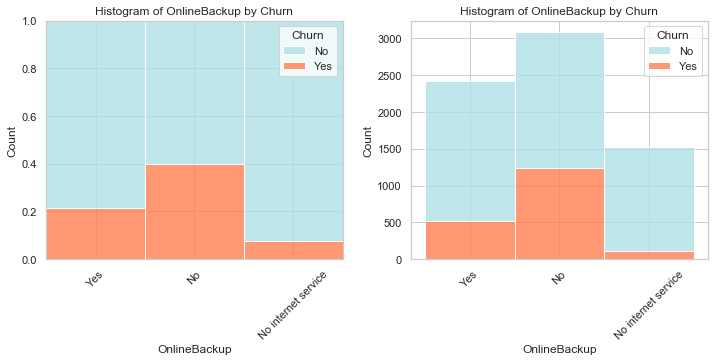

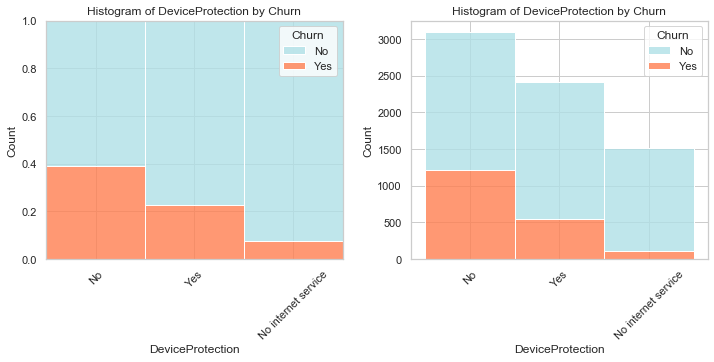

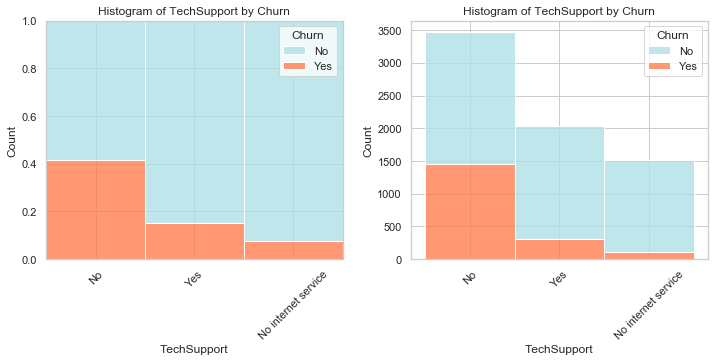

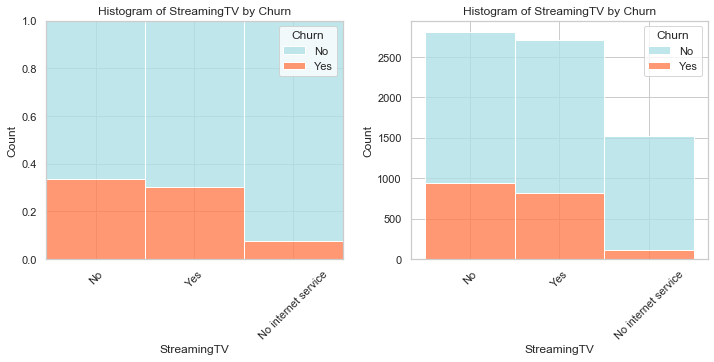

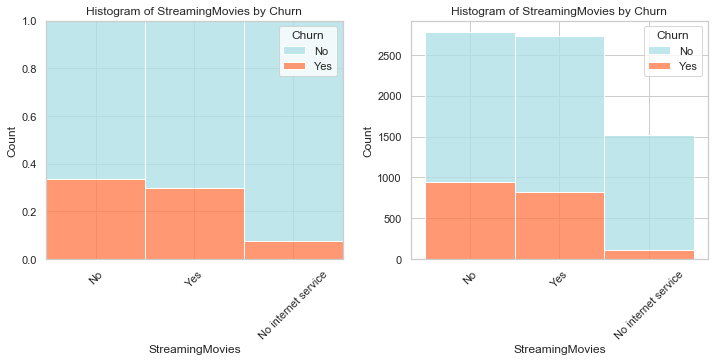

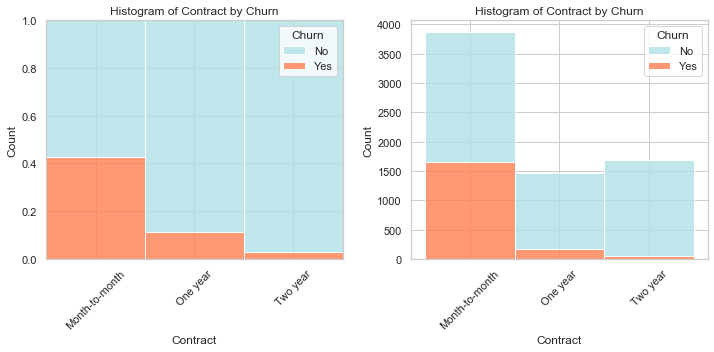

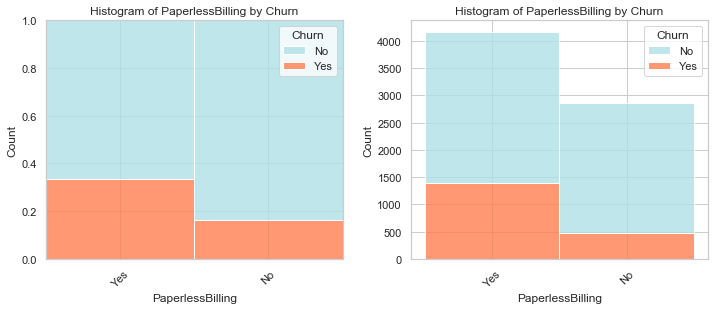

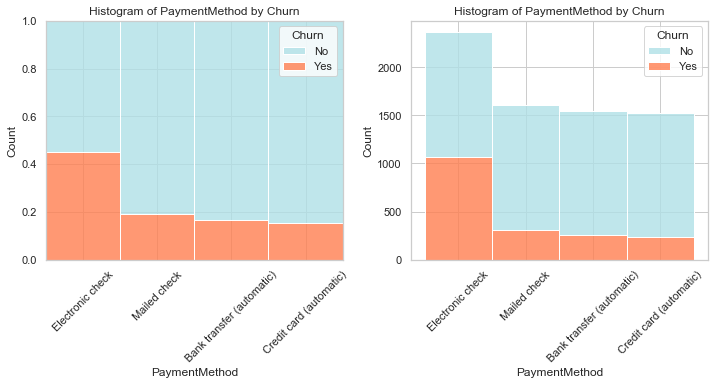

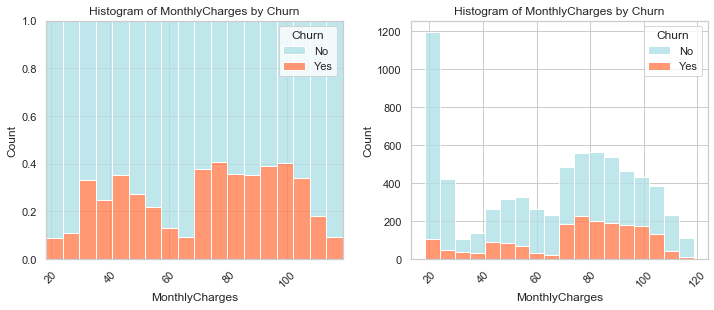

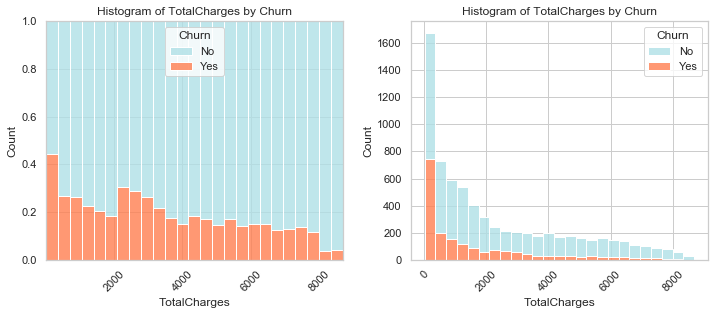

In [139]:
histhue(df_full, 'Churn', save=True)